In [1]:
import itertools
import sys
import uproot
import awkward as ak
import numpy as np
import pandas as pd
from coffea import nanoevents
import vector
import fastjet
from rich import print
from rich.progress import track
import math
import matplotlib.pyplot as plt
import matplotlib
import mplhep as hep
import hist
from hist import Hist

In [2]:
sys.path.insert(0, '../workflows/')

In [3]:
import SUEP_utils

In [4]:
matplotlib.rcParams.update({'figure.max_open_warning': 0})
hep.style.use(hep.style.CMS)

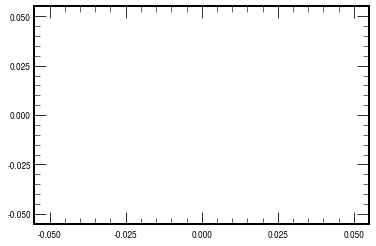

In [5]:
plt.plot();
hep.style.use(hep.style.CMS)

In [6]:
vector.register_awkward()

Number of events:

| Bin       | nMuon ≥ 6 | nMuon ≥ 5 |
| :-------: | :-------: | :-------: |
| 15To20    | 0         | 0         |
| 20To30    | 0         | 0         |
| 30To50    | 0         | 6         |
| 50To80    | 1         | 11        |
| 80To120   | 0         | 26        |
| 120To170  | 1         | 44        |
| 170To300  | 5         | 65        |
| 300To470  | 1         | 105       |
| 470To600  | 9         |
| 600To800  | 7         |
| 800To1000 | 11        |
| 1000      | 7         |

In [7]:
xrd_path = 'root://cmseos.fnal.gov//store/user'

signal = "GluGluToSUEP_T32p00_TuneCP5_13TeV_pythia8"
qcd = "QCD_Pt-300To470_MuEnrichedPt5_TuneCP5_13TeV-pythia8"

file = nanoevents.NanoEventsFactory.from_root(
    f"{xrd_path}/chpapage/SUEPNano_Jul2024_merged/{qcd}/skim_1.root",
    schemaclass=nanoevents.NanoAODSchema,
)
# file = nanoevents.NanoEventsFactory.from_root(
#     "root://cmseos.fnal.gov//store/user/chpapage/Central_NANO_split_merged/"
#     "GluGluToSUEP_T0p35_TuneCP5_13TeV_pythia8+RunIISummer20UL18NanoAODv9-"
#     "106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM/"
#     "GluGluToSUEP_mS800.000_mPhi1.400_T0.350_modehadronic_1.root",
#     entry_start=5000, entry_stop=6000
# )
events = file.events()

In [8]:
events

<NanoEventsArray [<event 1:20201:220492656>, ... ] type='36818 * event'>

In [9]:
muons = events.Muon

clean_muons = (
    (events.Muon.mediumId)
    & (events.Muon.pt > 3)
    & (abs(events.Muon.eta) < 2.4)
    & (abs(events.Muon.dxy) <= 0.02) 
    & (abs(events.Muon.dz) <= 0.1)
)

muons = muons[clean_muons]
select_by_muons_high = ak.num(muons, axis=-1) >= 3
events_ = events[select_by_muons_high]
muons = muons[select_by_muons_high]

In [10]:
muons

<MuonArray [[Muon, Muon, Muon, ... Muon, Muon]] type='16418 * var * muon'>

In [11]:
def match_muons_to_jets(jets, muons, delta_r=0.4):
    """
    Will match muons to each jet after checking the delta_r between them.
    """
    dr_jets_to_muons = jets.metric_table(muons)
    muons_per_jet = ak.unzip(ak.cartesian([jets, muons], nested=True))[1]
    muons_per_jet = muons_per_jet[dr_jets_to_muons < delta_r]
    return muons_per_jet

In [12]:
jets = events_.Jet[(events_.Jet.pt > 15) & (abs(events_.Jet.eta) < 2.4)]
muons_per_jet = match_muons_to_jets(jets, muons, delta_r=0.4)

In [19]:
print(ak.num(muons_per_jet, axis=-1))

[[0, 1, 1, 0], [0, 0, 3, 0], [0, 2, 1, 0, ... 1], [0, 1, 1, 0, 1, 1, 0], [1, 3, 0]]

In [ ]:
ak.num(muons_per_jet, axis=-1) > 2

In [21]:
~ak.any(ak.num(muons_per_jet, axis=-1) > 2, axis=-1)

<Array [True, False, True, ... True, False] type='16418 * bool'>

In [22]:
def get_num_muons_in_associated_jet(muons):
    # Get sorted jet idxs & their run lengths
    sorted_jetIdx = ak.sort(muons.jetIdx)
    run_lengths = ak.run_lengths(ak.materialized(sorted_jetIdx))
    # Group the idxs that have the same value
    grouped_idxs = ak.unflatten(
        ak.unflatten(ak.flatten(sorted_jetIdx), ak.flatten(run_lengths)),
        ak.num(run_lengths)
    )
    # Get the length of each idx group and broadcast it so that each  
    # muon has a number that corresponds to the length of its group
    num_muons_in_associated_jet = ak.flatten(
        ak.broadcast_arrays(ak.num(grouped_idxs, axis=-1), grouped_idxs)[0], 
        axis=-1
    )
    # Get the sorted local idxs
    sorted_local_idx = ak.local_index(muons.jetIdx)[ak.argsort(muons.jetIdx)]
    # Unsort the numbers and replace the number for -1 idxs with 0
    num_muons_in_associated_jet = num_muons_in_associated_jet[sorted_local_idx]
    num_muons_in_associated_jet = ak.where(muons.jetIdx == -1, 0, num_muons_in_associated_jet)
    return num_muons_in_associated_jet

In [23]:
num_muons_in_associated_jet = get_num_muons_in_associated_jet(muons)

In [30]:
num_muons_in_associated_jet[2]

<Array [2, 1, 2] type='3 * int64'>

In [37]:
ak.num(muons_per_jet, axis=-1)

<Array [[0, 1, 1, 0], [0, ... 1, 0], [1, 3, 0]] type='16418 * var * int64'>

In [40]:
print(muons_per_jet[ak.num(muons_per_jet, axis=-1) == 2])

[[], [], [[Muon, Muon]], [[Muon, Muon]], ... Muon]], [], [[Muon, Muon]], [], []]

In [41]:
muons_per_jet_with_2_muons = muons_per_jet[ak.num(muons_per_jet, axis=-1) == 2]

In [43]:
tights = muons_per_jet_with_2_muons.ip3d < 0.01
inverse = muons_per_jet_with_2_muons.ip3d >= 0.01

In [49]:
ak.sum(ak.sum(tights, axis=-1) == 2, axis=-1)

<Array [0, 0, 0, 1, 0, 0, ... 0, 0, 0, 0, 0, 0] type='16418 * int64'>

In [47]:
ak.sum(inverse, axis=-1)

<Array [[], [], [1], [0], ... [], [1], [], []] type='16418 * var * int64'>

In [32]:
print(muons_per_jet[2])

[[], [Muon, Muon], [Muon], [], [], []]

In [21]:
keep_jets_with_2_muons = ak.num(muons_per_jet, axis=-1) == 2
muons_per_2muon_jet = muons_per_jet[keep_jets_with_2_muons]

tight_muons_per_2muon_jet = muons_per_2muon_jet[muons_per_2muon_jet.ip3d < 0.01]
inverse_muons_per_2muon_jet = muons_per_2muon_jet[muons_per_2muon_jet.ip3d >= 0.01]

In [27]:
ak.num(muons_per_jet, axis=-1)

<Array [[], [], [2], [2], ... [], [2], [], []] type='16418 * var * int64'>

In [26]:
ak.num(muons_per_jet_tight, axis=-1)

<Array [[], [], [1], [2], ... [], [1], [], []] type='16418 * var * int64'>

In [28]:
ak.num(muons_per_jet_inverse, axis=-1)

<Array [[], [], [1], [0], ... [], [1], [], []] type='16418 * var * int64'>

In [13]:
sorted_muons = muons[ak.argsort(muons.jetIdx, axis=-1)]
run_lengths = ak.run_lengths(ak.sort(muons.jetIdx, axis=-1))


In [14]:
print(sorted_muons)
print(run_lengths)

[[Muon, Muon, Muon], [Muon, Muon, Muon], ... Muon, Muon], [Muon, Muon, Muon, Muon]]

[[1, 1, 1], [3], [2, 1], [1, 2], [1, 1, ... [1, 1, 1], [2, 1], [1, 1, 1], [1, 3]]

In [32]:
ak.num(muons)

<Array [3, 3, 3, 3, 3, 4, ... 3, 3, 3, 3, 3, 4] type='16418 * int64'>

In [31]:
ak.sort(muons.jetIdx)

<Array [[-1, 1, 2], [2, 2, ... [0, 1, 1, 1]] type='16418 * var * int32[parameter...'>

In [34]:
ak.flatten(ak.run_lengths(ak.sort(muons.jetIdx)))

<Array [1, 1, 1, 3, 2, 1, ... 1, 1, 1, 1, 1, 3] type='37874 * int64'>

In [43]:
ak.num(ak.run_lengths(ak.sort(muons.jetIdx)))

<Array [3, 1, 2, 2, 3, 4, ... 2, 2, 3, 2, 3, 2] type='16418 * int64'>

In [33]:
ak.flatten(ak.sort(muons.jetIdx))

<Array [-1, 1, 2, 2, 2, 2, ... 5, 0, 1, 1, 1] type='50906 * int32[parameters={"_...'>

In the following array, the jet idxs are sorted and grouped together when the same number

### What do I need?

I want for each muon to have the number of muons that are associated in its jet.
E.g., 

    - if it's not associated to a jet --> 0
    - if it's associated to a jet with one muon (itself) --> 1
    - if it's associated to a jet with two muons (itself & another one) --> 2
    - etc ...
    
```python
# For example, the following idxs 
[[1, 2, -1], [2, 2, 2], [1, 2, 1]]

# should give the following array
[[1, 1, 0], [3, 3, 3], [2, 1, 2]]
```

In [13]:
sorted_jetIdx = ak.sort(muons.jetIdx)

In [15]:
run_lengths = ak.run_lengths(ak.materialized(sorted_jetIdx))

In [16]:
grouped_idxs = ak.unflatten(
    ak.unflatten(ak.flatten(sorted_jetIdx), ak.flatten(run_lengths)),
    ak.num(run_lengths)
)

In [17]:
num_muons_in_associated_jet = ak.flatten(
    ak.broadcast_arrays(ak.num(grouped_idxs, axis=-1), grouped_idxs)[0], 
    axis=-1
)

In [18]:
sorted_local_idx = ak.local_index(muons.jetIdx)[ak.argsort(muons.jetIdx)]

# Unsort the numbers and replace the number for -1 idxs with 0
num_muons_in_associated_jet = num_muons_in_associated_jet[sorted_local_idx]
num_muons_in_associated_jet = ak.where(muons.jetIdx == -1, 0, num_muons_in_associated_jet)

In [19]:
num_muons_in_associated_jet

<Array [[5, 5, 5, 5, 5], ... 8], [2, 1, 2]] type='8 * var * int64'>

In [23]:
def get_num_muons_in_associated_jet(muons):
    # Get sorted jet idxs & their run lengths
    sorted_jetIdx = ak.sort(muons.jetIdx)
    run_lengths = ak.run_lengths(sorted_jetIdx)

    # Group the idxs that have the same value
    grouped_idxs = ak.unflatten(
        ak.unflatten(ak.flatten(sorted_jetIdx), ak.flatten(run_lengths)),
        ak.num(run_lengths)
    )

    # Get the length of each idx group and broadcast it so that each  
    # muon has a number that corresponds to the length of its group
    num_muons_in_associated_jet = ak.flatten(
        ak.broadcast_arrays(ak.num(grouped_idxs, axis=-1), grouped_idxs)[0], 
        axis=-1
    )

    # Get the sorted local idxs
    sorted_local_idx = ak.local_index(muons.jetIdx)[ak.argsort(muons.jetIdx)]

    # Unsort the numbers and replace the number for -1 idxs with 0
    num_muons_in_associated_jet = num_muons_in_associated_jet[sorted_local_idx]
    num_muons_in_associated_jet = ak.where(muons.jetIdx == -1, 0, num_muons_in_associated_jet)
    
    return num_muons_in_associated_jet

In [24]:
get_num_muons_in_associated_jet(muons)

<Array [[5, 5, 5, 5, 5]] type='1 * var * int64'>

In [25]:
ak.__version__

'1.10.5'

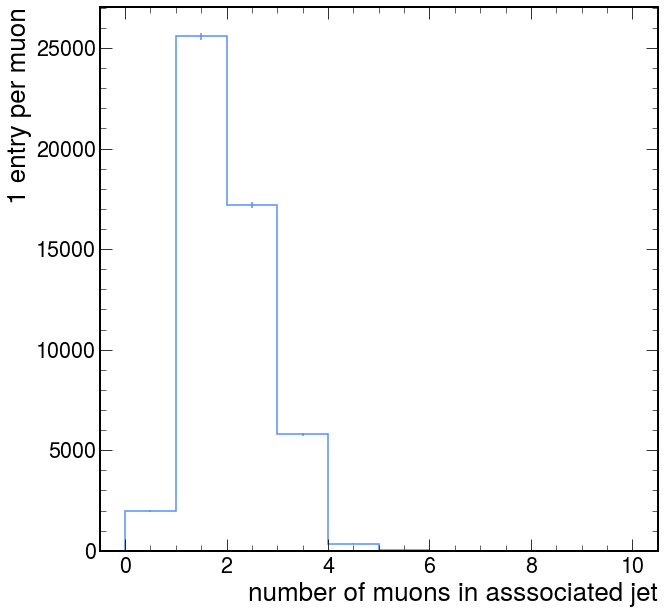

In [159]:
hist.Hist.new.Reg(
    10, 0, 10, name="number of muons in asssociated jet"
).Double().fill(ak.flatten(num_muons_in_associated_jet)).plot()
plt.ylabel("1 entry per muon")
#plt.yscale('log')
plt.show()

In [25]:
muons.pt

<Array [[25.4, 15.6, 3.15, ... 15, 8.65, 4.39]] type='16418 * var * float32[para...'>

In [ ]:
muons_jetIdx_sanitized = ak.where(muons.jetIdx >= 0, muons.jetIdx, 0)
muon_is_not_from_b = ak.where(muons.jetIdx >= 0, events_.Jet[muons_jetIdx_sanitized].btagDeepFlavB < 0.05, True)

In [16]:
charged_pfcands_fromPV = events.PFCands[(events.PFCands.fromPV > 1) & (abs(events.PFCands.charge) > 0)]
neutral_pfcands = events.PFCands[abs(events.PFCands.charge) == 0]
charged_pfcands_PU = events.PFCands[(events.PFCands.fromPV < 2) & (abs(events.PFCands.charge) > 0)]

In [31]:
sum_charged_fromPV = ak.sum(charged_pfcands_fromPV.pt, axis=-1)

In [32]:
sum_neutrals_fromPV = (
    ak.sum(np.sqrt(neutral_pfcands.pt**2 + neutral_pfcands.mass**2), axis=-1) 
    - 0.5 * ak.sum(charged_pfcands_PU.pt, axis=-1)
)

In [33]:
sum_charged_fromPV + ak.where(sum_neutrals_fromPV > 0, sum_neutrals_fromPV, 0)

<Array [962, 1.31e+03, ... 1.33e+03, 1.57e+03] type='36818 * float64'>

In [38]:
events.PFCands.metric_table(muons)

AttributeError: no field named 'metric_table'

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.5/src/awkward/highlevel.py#L1124)

In [13]:
print(events.Muon[:5, :2].metric_table(events.PFCands[:5, :5]).to_list())

[
    [
        [1.4173609018325806, 3.431093454360962, 3.706430435180664, 1.4289820194244385, 1.9336012601852417],
        [1.3214257955551147, 3.218701124191284, 3.508375644683838, 1.0902553796768188, 1.7297099828720093]
    ],
    [
        [1.2101398706436157, 1.01400625705719, 1.456783413887024, 1.3686063289642334, 0.8677582144737244],
        [1.110810399055481, 1.0661840438842773, 1.4286233186721802, 1.2932372093200684, 0.8904905319213867]
    ],
    [
        [1.458931565284729, 1.9407740831375122, 3.334825038909912, 1.7396124601364136, 3.5364830493927],
        [1.1894280910491943, 2.431265354156494, 2.5269908905029297, 2.576469898223877, 2.742349863052368]
    ],
    [
        [2.389268159866333, 2.243618965148926, 0.7242504358291626, 2.642986536026001, 1.0753984451293945],
        [2.513218879699707, 2.2914483547210693, 0.8477538824081421, 2.5608739852905273, 0.9492290019989014]
    ],
    [
        [0.18354293704032898, 2.148602247238159, 1.8621859550476074, 3.1442854404449463, 1.1383280754089355],
        [0.1785682737827301, 2.1402177810668945, 1.8394248485565186, 3.13179349899292, 1.1254041194915771]
    ]
]

In [ ]:
events.Muon

In [35]:
pfcands

<NanoCollectionArray [[{d0: -6.39, ... trkQuality: 5}]] type='36818 * var * stru...'>

In [ ]:
def pf_iso_replicator(muons, pfcands, R=0.4):
    dR_dist = pfcands.metric_table(muons)
    charged_pfcands_fromPV = events.PFCands[
        (events.PFCands.fromPV > 1) & 
        (abs(events.PFCands.charge) > 0) &
        (dR_dist < R)
    ]
    neutral_pfcands = events.PFCands[
        (abs(events.PFCands.charge) == 0) &
        (dR_dist < R)
    ]
    charged_pfcands_PU = events.PFCands[
        (events.PFCands.fromPV < 2) & 
        (abs(events.PFCands.charge) > 0) &
        (dR_dist < R)
    ]
    sum_charged_fromPV = ak.sum(charged_pfcands_fromPV.pt, axis=-1)
    sum_neutrals_fromPV = (
        ak.sum(np.sqrt(neutral_pfcands.pt**2 + neutral_pfcands.mass**2), axis=-1) 
        - 0.5 * ak.sum(charged_pfcands_PU.pt, axis=-1)
    )
    return sum_charged_fromPV + ak.where(sum_neutrals_fromPV > 0, sum_neutrals_fromPV, 0)

In [9]:
def match_muons_to_jets(jets, muons, delta_r=0.4):
    """
    Will match muons to each jet after checking the delta_r between them.
    """
    dr_jets_to_muons = jets.metric_table(muons)
    muons_per_jet = ak.unzip(ak.cartesian([jets, muons], nested=True))[1]
    muons_per_jet = muons_per_jet[dr_jets_to_muons < delta_r]
    return muons_per_jet

def mini_iso_cone_size(muons):
    """
    Calculate the miniPFRelIso_all cone size for each muon.
    This is 0.2 for muons with pt <= 50, 0.05 for muons with pt >= 200, and 10/pt for muons with 50 < pt < 200.
    """
    return ak.where(
        muons.pt <= 50, 
        0.2, 
        ak.where(muons.pt >= 200, 0.05, 10 / muons.pt)
    )


def muon_iso_sub_muons(muons_for_iso, muons_all):
    """
    Subtract the isolation of other muons from the isolation of the muon.
    """
    dR_muons = ak.fill_none(muons_for_iso.metric_table(muons_all), [], axis=0)
    muons_for_iso_broadcasted, muons_in_cone = ak.unzip(ak.cartesian([muons_for_iso, muons_all], nested=True))
    cone_size = mini_iso_cone_size(muons_for_iso_broadcasted)
    muons_in_cone = muons_in_cone[dR_muons < cone_size]
    muon_contributions = (
        ak.sum(muons_in_cone.pt, axis=-1) - muons_for_iso.pt
    ) / muons_for_iso.pt
    return muons_for_iso.miniPFRelIso_all - muon_contributions

In [13]:
jets = events_.Jet[(events_.Jet.pt > 15) & (abs(events_.Jet.eta) < 2.4)]
muons_per_jet = match_muons_to_jets(jets, muons, delta_r=0.4)

# muons_per_jet = muons_per_jet[ak.num(muons_per_jet, axis=-1) == 3]
# events_ = events_[ak.num(muons_per_jet, axis=1) > 0]
# muons = muons[ak.num(muons_per_jet, axis=1) > 0]
# jets = jets[ak.num(muons_per_jet, axis=1) > 0]
# muons_per_jet = muons_per_jet[ak.num(muons_per_jet, axis=1) > 0]

In [17]:
print(muons[:2])

[[Muon, Muon, Muon], [Muon, Muon, Muon]]

In [18]:
print(jets[:2])

[[Jet, Jet, Jet, Jet], [Jet, Jet, Jet, Jet, Jet, Jet, Jet]]

In [21]:
print(muons_per_jet[:2])

[[[], [], [Muon, Muon, Muon], []], [[], [Muon, Muon, Muon], [], [], [], [], []]]

In [24]:
ak.all(ak.num(muons_per_jet, axis=-1) == 0, axis=-1)

<Array [False, False, False, ... False, False] type='1978 * bool'>

In [12]:
unpacked_muons_iso_sub_muons = []
for iMuon in range(ak.max(ak.num(muons))):
    muon_i = muons[:, iMuon:(iMuon+1)]
    muon_i_iso_sub_muons = muon_iso_sub_muons(muon_i, muons)
    unpacked_muons_iso_sub_muons.append(muon_i_iso_sub_muons)
muons_iso_sub_muons = ak.concatenate(unpacked_muons_iso_sub_muons, axis=-1)

In [13]:
muon_0 = muons_per_jet[:, :, 0]
muon_1 = muons_per_jet[:, :, 1]
muon_2 = muons_per_jet[:, :, 2]
muon_0_iso_sub_muons = muon_iso_sub_muons(muon_0, muons)
muon_1_iso_sub_muons = muon_iso_sub_muons(muon_1, muons)
muon_2_iso_sub_muons = muon_iso_sub_muons(muon_2, muons)

In [53]:
print(ak.concatenate([muon_0_iso_sub_muons, muon_1_iso_sub_muons, muon_2_iso_sub_muons], axis=-1))

[[1.15, 2.83, 0.0861], [3.04, 2.13, 3.16, ... -1.4, 3.23], [0.555, 0.208, -1.63]]

In [55]:
print(muons_per_jet.miniPFRelIso_all)

[[[1.15, 2.83, 0.0861]], [[3.04, 2.66, 5.07, ... 10.5, 3.23]], [[0.773, 5.39, 8.06]]]

In [56]:
muon_0_iso_sub_muons < 0.3

<Array [[False], [False], ... [False], [False]] type='1978 * var * bool'>

In [57]:
muon_1_iso_sub_muons < 0.3

<Array [[False], [False], ... [True], [True]] type='1978 * var * bool'>

In [58]:
muon_2_iso_sub_muons < 0.3

<Array [[True], [False], ... [False], [True]] type='1978 * var * bool'>

In [61]:
nTight = (
    ak.values_astype(muon_0_iso_sub_muons < 0.3, np.int32)
    + ak.values_astype(muon_1_iso_sub_muons < 0.3, np.int32)
    + ak.values_astype(muon_2_iso_sub_muons < 0.3, np.int32)
)

In [67]:
ak.sum(ak.any((nTight == 3), axis=-1) & (ak.num(muons) == 5))

4

In [70]:
pf_cands = events.PFCands

In [75]:
ak.num(events.PFCands)

<Array [1765, 2043, 1570, ... 2004, 1898, 1449] type='36818 * int64'>

In [73]:
pf_cands = pf_cands[pf_cands.charge == 0]

In [91]:
ak.num(pf_cands)

<Array [970, 1081, 881, ... 1029, 1001, 880] type='36818 * int64'>

In [82]:
ak.sum(pf_cands.trkPt > 0, axis=-1)

204

In [93]:
ak.sum(abs(pf_cands.dz) < 10, axis=-1)

<Array [970, 1081, 881, ... 1029, 1001, 880] type='36818 * int64'>

In [95]:
ak.sum(pf_cands.dzErr < 0.05, axis=-1)

<Array [970, 1081, 881, ... 1029, 1001, 880] type='36818 * int64'>

In [96]:
cut = (
    (pf_cands.fromPV > 1)
    & (pf_cands.pt >= 0.75)
    & (abs(pf_cands.eta) <= 2.5)
    & (abs(pf_cands.dz) < 10)
    & (pf_cands.dzErr < 0.05)
)
pf_cands = pf_cands[cut]

In [98]:
ak.num(pf_cands)

<Array [75, 110, 70, 96, ... 118, 74, 107, 105] type='36818 * int64'>

In [17]:
def mini_iso_cone_size(muons):
    """
    Calculate the miniPFRelIso_all cone size for each muon.
    This is 0.2 for muons with pt <= 50, 0.05 for muons with pt >= 200, and 10/pt for muons with 50 < pt < 200.
    """
    return ak.where(
        muons.pt <= 50, 
        0.2, 
        ak.where(muons.pt >= 200, 0.05, 10 / muons.pt)
    )

def muon_iso_sub_muons(muons_for_iso, muons_all):
    """
    Subtract the isolation of other muons from the isolation of the muon.
    """
    dR_muons = ak.fill_none(muons_for_iso.metric_table(muons), [], axis=0)
    muons_for_iso_broadcasted, muons_in_cone = ak.unzip(ak.cartesian([muons_for_iso, muons_all], nested=True))
    cone_size = mini_iso_cone_size(muons_for_iso_broadcasted)
    muons_in_cone = muons_in_cone[dR_muons < cone_size]
    muon_contributions = (
        ak.sum(muons_in_cone.pt, axis=-1) - muons_for_iso.pt
    ) / muons_for_iso.pt
    return muons_for_iso.miniPFRelIso_all - muon_contributions

In [18]:
muon_4 = muons[:, 3:4]
muon_iso_sub_muons(muon_4, muons)

<Array [[], [], [], [], ... [], [], [93]] type='16418 * var * float32'>

In [24]:
muon_4.miniPFRelIso_all

<Array [[], [], [], [], ... [], [], [93]] type='16418 * var * float32[parameters...'>

In [19]:
muon_4

<MuonArray [[], [], [], [], ... [], [], [Muon]] type='16418 * var * muon'>

In [41]:
muons_for_iso_broadcasted

<MuonArray [None, None, None, ... None, None, None] type='16418 * option[1 * var...'>

In [25]:
unpacked_muons_iso_sub_muons = []
for iMuon in range(ak.max(ak.num(muons))):
    muon_i = muons[:, iMuon:(iMuon+1)]
    muon_i_iso_sub_muons = muon_iso_sub_muons(muon_i, muons)
    unpacked_muons_iso_sub_muons.append(muon_i_iso_sub_muons)
muons_iso_sub_muons = ak.concatenate(unpacked_muons_iso_sub_muons, axis=-1)

In [23]:
unpacked_muons

[<MuonArray [[Muon], [Muon], ... [Muon], [Muon]] type='16418 * var * muon'>,
 <MuonArray [[Muon], [Muon], ... [Muon], [Muon]] type='16418 * var * muon'>,
 <MuonArray [[Muon], [Muon], ... [Muon], [Muon]] type='16418 * var * muon'>,
 <MuonArray [[], [], [], [], ... [], [], [Muon]] type='16418 * var * muon'>,
 <MuonArray [[], [], [], [], ... [], [], [], []] type='16418 * var * muon'>,
 <MuonArray [[], [], [], [], ... [], [], [], []] type='16418 * var * muon'>]

In [26]:
unpacked_muons_iso_sub_muons

[<Array [[3], [1.15], ... [3.09], [0.555]] type='16418 * var * float32'>,
 <Array [[0], [2.83], ... [1.77], [0.208]] type='16418 * var * float32'>,
 <Array [[0], [0.0861], ... [2.96], [-1.63]] type='16418 * var * float32'>,
 <Array [[], [], [], [], ... [], [], [93]] type='16418 * var * float32'>,
 <Array [[], [], [], [], ... [], [], [], []] type='16418 * var * float32'>,
 <Array [[], [], [], [], ... [], [], [], []] type='16418 * var * float32'>]

[[3, 0, 0], [1.15, 2.83, 0.0861], ... 3.09, 1.77, 2.96], [0.555, 0.208, -1.63, 93]]

In [20]:
muons[:, 3:4]

<MuonArray [[], [], [], [], ... [], [], [Muon]] type='16418 * var * muon'>

In [13]:
# Get the associated muons from the jets & make sure there are two of them.
jets = events_.Jet[(events_.Jet.pt > 15) & (abs(events_.Jet.eta) < 2.4)]
jets = jets[(jets.muonIdx1 > -1) & (jets.muonIdx2 > -1)]
muons1_from_jet = events_.Muon[jets.muonIdx1]
muons2_from_jet = events_.Muon[jets.muonIdx2]

In [ ]:
ak.values_astype(jets.pt > 200, np.int32)

In [ ]:
muons1_from_jet.pt

In [ ]:
ak.flatten(muons1_from_jet)

In [ ]:
muons2_from_jet.pt

In [11]:
ak.flatten(muons2_from_jet)

NameError: name 'muons2_from_jet' is not defined

In [18]:
print(muons)

[[Muon, Muon, Muon], [Muon, Muon, Muon], ... Muon, Muon], [Muon, Muon, Muon, Muon]]

In [21]:
ak.sum(jets.metric_table(muons) < 0.4, axis=-1) == 2

<Array [[False], [False], ... [], [False]] type='16418 * var * bool'>

In [14]:
# Apply cleaing cuts to the muons from the jets
clean_muons1_from_jet = (
    (muons1_from_jet.mediumId)
    & (muons1_from_jet.pt > 3)
    & (abs(muons1_from_jet.eta) < 2.4)
    & (abs(muons1_from_jet.dxy) <= 0.02) 
    & (abs(muons1_from_jet.dz) <= 0.1)
)
clean_muons2_from_jet = (
    (muons2_from_jet.mediumId)
    & (muons2_from_jet.pt > 3)
    & (abs(muons2_from_jet.eta) < 2.4)
    & (abs(muons2_from_jet.dxy) <= 0.02) 
    & (abs(muons2_from_jet.dz) <= 0.1)
)

In [15]:
print(clean_muons1_from_jet[:10])

[[False], [True], [True], [False, True], ... [True], [True], [False], [], [True]]

In [16]:
print(clean_muons2_from_jet[:10])

[[True], [True], [True], [False, True], ... [False], [False], [False], [], [True]]

In [17]:
clean_muons1_from_jet & clean_muons2_from_jet

<Array [[False], [True], ... [], [False]] type='16418 * var * bool'>

In [18]:
muons1_from_jet = muons1_from_jet[clean_muons1_from_jet & clean_muons2_from_jet]
muons2_from_jet = muons2_from_jet[clean_muons1_from_jet & clean_muons2_from_jet]

In [110]:
print(muons1_from_jet)

[[], [Muon], [Muon], [Muon], [], [], [], ... [], [Muon], [Muon], [], [Muon], [], []]

In [111]:
print(muons2_from_jet)

[[], [Muon], [Muon], [Muon], [], [], [], ... [], [Muon], [Muon], [], [Muon], [], []]

In [19]:
# Keep only events with jets with two muons
events_ = events_[ak.num(muons1_from_jet) > 0]
muons = muons[ak.num(muons1_from_jet) > 0]
muons1_from_jet = muons1_from_jet[ak.num(muons2_from_jet) > 0]
muons2_from_jet = muons2_from_jet[ak.num(muons2_from_jet) > 0]

In [20]:
events_

<NanoEventsArray [<event 1:20202:220503572>, ... ] type='7446 * event'>

In [21]:
muons

<MuonArray [[Muon, Muon, Muon, ... Muon, Muon]] type='7446 * var * muon'>

In [22]:
muons1_from_jet

<MuonArray [[Muon], [Muon], ... [Muon], [Muon]] type='7446 * var * muon'>

In [23]:
muons2_from_jet

<MuonArray [[Muon], [Muon], ... [Muon], [Muon]] type='7446 * var * muon'>

In [24]:
ak.sum(muons1_from_jet.miniPFRelIso_all < 1, axis=-1) + ak.sum(muons1_from_jet.miniPFRelIso_all >= 1, axis=-1)

<Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='7446 * int64'>

In [25]:
ak.sum(muons1_from_jet.miniPFRelIso_all < 1, axis=-1) + ak.sum(muons2_from_jet.miniPFRelIso_all < 1, axis=-1)

<Array [0, 1, 0, 1, 1, 0, ... 1, 0, 1, 0, 0, 1] type='7446 * int64'>

In [26]:
ak.sum(muons1_from_jet.miniPFRelIso_all >= 1, axis=-1) + ak.sum(muons2_from_jet.miniPFRelIso_all >= 1, axis=-1)

<Array [2, 1, 2, 1, 1, 2, ... 1, 2, 1, 2, 2, 1] type='7446 * int64'>

In [27]:
(
    ak.sum(muons1_from_jet.miniPFRelIso_all < 1, axis=-1) + ak.sum(muons2_from_jet.miniPFRelIso_all < 1, axis=-1) + 
    ak.sum(muons1_from_jet.miniPFRelIso_all >= 1, axis=-1) + ak.sum(muons2_from_jet.miniPFRelIso_all >= 1, axis=-1)
)

<Array [2, 2, 2, 2, 2, 2, ... 2, 2, 2, 2, 2, 2] type='7446 * int64'>

In [39]:
delta_r = ak.firsts(muons1_from_jet).delta_r(muons)

In [53]:
R_muons1_iso_sub_muon = ak.where(
    muons1_from_jet.pt <= 50, 0.2, ak.where(muons1_from_jet.pt >= 200, 0.05, 10 / muons1_from_jet.pt)
)

In [45]:
R_muons1_iso_sub_muon

<Array [[0.2], [0.05], ... [0.2], [0.2]] type='7446 * var * float64'>

In [52]:
print(ak.firsts(muons1_from_jet.pt))

[24.1, 62.9, 24.4, 29.7, 10.2, 12.9, 12.5, ... 21.3, 10.2, 64, 12.1, 28.1, 11.2]

In [55]:
R_muons1_iso_sub_muon_broadcast = ak.broadcast_arrays(delta_r, ak.firsts(R_muons1_iso_sub_muon))[1]

In [61]:
(ak.sum(muons[delta_r < R_muons1_iso_sub_muon_broadcast].pt, axis=-1) - muons1_from_jet.pt) / muons1_from_jet.pt

<Array [[0], [0.148], ... [0.426], [0]] type='7446 * option[var * float32]'>

In [66]:
R_muons1_iso_sub_muon = ak.where(muons1_from_jet.pt <= 50, 0.2, ak.where(muons1_from_jet.pt >= 200, 0.05, 10 / muons1_from_jet.pt))
R_muons2_iso_sub_muon = ak.where(muons2_from_jet.pt <= 50, 0.2, ak.where(muons2_from_jet.pt >= 200, 0.05, 10 / muons2_from_jet.pt))
dR_muons1_iso_sub_muon = ak.firsts(muons1_from_jet).delta_r(muons)
dR_muons2_iso_sub_muon = ak.firsts(muons2_from_jet).delta_r(muons)
R_muons1_iso_sub_muon = ak.broadcast_arrays(dR_muons1_iso_sub_muon, ak.firsts(R_muons1_iso_sub_muon))[1]
R_muons2_iso_sub_muon = ak.broadcast_arrays(dR_muons2_iso_sub_muon, ak.firsts(R_muons2_iso_sub_muon))[1]

In [70]:
muons[dR_muons1_iso_sub_muon < R_muons1_iso_sub_muon]

<MuonArray [[Muon], [Muon, Muon, ... Muon], [Muon]] type='7446 * option[var * muon]'>

In [74]:
R_muons1_iso_sub_muon = ak.where(muons1_from_jet.pt <= 50, 0.2, ak.where(muons1_from_jet.pt >= 200, 0.05, 10 / muons1_from_jet.pt))
R_muons2_iso_sub_muon = ak.where(muons2_from_jet.pt <= 50, 0.2, ak.where(muons2_from_jet.pt >= 200, 0.05, 10 / muons2_from_jet.pt))
dR_muons1_iso_sub_muon = ak.firsts(muons1_from_jet).delta_r(muons)
dR_muons2_iso_sub_muon = ak.firsts(muons2_from_jet).delta_r(muons)
R_muons1_iso_sub_muon = ak.broadcast_arrays(dR_muons1_iso_sub_muon, ak.firsts(R_muons1_iso_sub_muon))[1]
R_muons2_iso_sub_muon = ak.broadcast_arrays(dR_muons2_iso_sub_muon, ak.firsts(R_muons2_iso_sub_muon))[1]
muon_factor_1 = (ak.sum(muons[dR_muons1_iso_sub_muon < R_muons1_iso_sub_muon].pt, axis=-1) - ak.firsts(muons1_from_jet).pt) / ak.firsts(muons1_from_jet).pt
muon_factor_2 = (ak.sum(muons[dR_muons2_iso_sub_muon < R_muons2_iso_sub_muon].pt, axis=-1) - ak.firsts(muons2_from_jet).pt) / ak.firsts(muons2_from_jet).pt
muons1_iso_sub_muon = muons1_from_jet.miniPFRelIso_all - muon_factor_1
muons2_iso_sub_muon = muons2_from_jet.miniPFRelIso_all - muon_factor_2
nTight = ak.values_astype(muons1_iso_sub_muon < 0.3, np.int32) + ak.values_astype(muons2_iso_sub_muon < 0.3, np.int32)
nInverse = ak.values_astype(muons1_iso_sub_muon >= 0.3, np.int32) + ak.values_astype(muons2_iso_sub_muon >= 0.3, np.int32)

In [75]:
muon_factor_1

<Array [0, 0.148, 0.61, 0, ... 0.991, 0.426, 0] type='7446 * ?float32'>

In [78]:
ak.firsts(muons1_from_jet.miniPFRelIso_chg) - muon_factor_1

<Array [0.448, 0.211, 0.856, ... 3.54, 0.628] type='7446 * ?float32'>

In [25]:
ak.sum(muons1_from_jet.miniPFRelIso_all < 1, axis=-1) + ak.sum(muons1_from_jet.miniPFRelIso_all >= 1, axis=-1)

<Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='7334 * int64'>

In [21]:
ak.sum(muons2_from_jet.miniPFRelIso_all < 1, axis=-1)

<Array [0, 0, 0, 1, 0, 0, ... 0, 0, 0, 0, 0, 1] type='7334 * int64'>

In [15]:
ak.flatten(muons2_from_jet)

<MuonArray [Muon, Muon, Muon, ... Muon, Muon, Muon] type='7334 * muon'>

In [ ]:
## Match muons to jets 

In [79]:
jets = events.Jet[(events.Jet.pt > 15) & (abs(events.Jet.eta) < 2.4)]
clean_muons = (
    (events.Muon.mediumId)
    & (events.Muon.pt > 3)
    & (abs(events.Muon.eta) < 2.4)
    & (abs(events.Muon.dxy) <= 0.02) 
    & (abs(events.Muon.dz) <= 0.1)
)
muons = events.Muon[clean_muons]

In [81]:
jets[0]

<JetArray [Jet, Jet, Jet, Jet] type='4 * jet'>

In [82]:
muons[0]

<MuonArray [Muon, Muon, Muon] type='3 * muon'>

In [103]:
muons_per_jet = ak.unzip(ak.cartesian([jets, muons], nested=True))[1]

In [105]:
muons_per_jet = muons_per_jet[jets.metric_table(muons) < 0.4]

In [109]:
muons_per_jet = muons_per_jet[ak.num(muons_per_jet, axis=-1) == 3]

In [117]:
muons = muons[ak.num(muons_per_jet, axis=1) > 0]
muons_per_jet = muons_per_jet[ak.num(muons_per_jet, axis=1) > 0]

In [162]:
muon_0 = muons_per_jet[:, :, 0]

In [187]:
ak.local_index(muon_0, axis=0)[ak.num(muon_0) > 1]

<Array [524, 656, 709, 1471] type='4 * int64'>

In [172]:
muon_0.metric_table(muons)[-1]

<Array [[0, 0.133, 0.173, 3.05]] type='1 * var * float32'>

In [171]:
muons[-1]

<MuonArray [Muon, Muon, Muon, Muon] type='4 * muon'>

In [179]:
print(muon_0.pt[0])

[24.1]

In [180]:
print(muons.pt[0])

[24.1, 8.4, 6.11]

In [188]:
print(ak.unzip(ak.cartesian([muon_0, muons], nested=True))[0][524].pt)
print(ak.unzip(ak.cartesian([muon_0, muons], nested=True))[1][524].pt)

[[11, 11, 11, 11], [11, 11, 11, 11]]

[[11, 10.5, 5.16, 3.22], [11, 10.5, 5.16, 3.22]]

In [148]:
print(ak.unzip(ak.cartesian([muons_per_jet, ak.singletons(muons)], nested=True, axis=1))[-1])

[[[Muon, Muon, Muon]], [[Muon, Muon, Muon, ... Muon]], [[Muon, Muon, Muon, Muon]]]

In [151]:
print(muons.metric_table(muons_per_jet)[-1].to_list())

[
    [[0.0, 0.13264651596546173, 0.17349202930927277]],
    [[0.13264651596546173, 0.0, 0.09863292425870895]],
    [[0.17349202930927277, 0.09863292425870895, 0.0]],
    [[3.054711103439331, 3.103403091430664, 3.0969645977020264]]
]

In [207]:
dR_muons = muon_0.metric_table(muons)
muon_0_broadcasted, muons_in_cone = ak.unzip(ak.cartesian([muon_0, muons], nested=True))
cone_size = ak.where(
    muon_0_broadcasted.pt <= 50, 
    0.2, 
    ak.where(muon_0_broadcasted.pt >= 200, 0.05, 10 / muon_0_broadcasted.pt)
)
muons_in_cone = muons_in_cone[dR_muons < cone_size]
muon_contributions = (
    ak.sum(muons_in_cone.pt, axis=-1) - muon_0.pt
) / muon_0.pt

[11, 11]

[11, 10.5, 5.16, 3.22]

[[0, 0.107, 0.246, 3.1], [0, 0.107, 0.246, 3.1]]

[[0.2, 0.2, 0.2, 0.2], [0.2, 0.2, 0.2, 0.2]]

[[Muon, Muon], [Muon, Muon]]

[23.2, 23.2]

[0.959, 0.959]

[22.3, 22.3]

In [226]:

ak.argmax((events_.luminosityBlock == 20202) & (events_.event == 220504401))

1

In [225]:
events_.luminosityBlock

<Array [20202, 20202, 33118, ... 18359, 18359] type='7446 * uint32[parameters={"...'>

In [221]:
events_.event

<Array [220503572, 220504401, ... 200387476] type='7446 * uint64[parameters={"__...'>

In [212]:
ak.any(muon_contributions < 0.1, axis=-1)

<Array [True, True, False, ... True, False] type='1978 * bool'>

In [198]:
dR_muons

<Array [[[0, 0.202, 0.402, ... 0.173, 3.05]]] type='1978 * var * var * float32'>

In [199]:
cone_size

<Array [[[0.2, 0.2, 0.2], ... 0.2, 0.2, 0.2]]] type='1978 * var * var * float64'>

<Array [[1.15], [3.04], ... [0.735], [0.43]] type='1978 * var * float32'>

In [155]:
ak.singletons(muons)

<MuonArray [[Muon, Muon, Muon, ... Muon, Muon]] type='1978 * var * muon'>

In [153]:
muons

<MuonArray [[Muon, Muon, Muon, ... Muon, Muon]] type='1978 * var * muon'>

In [ ]:
def match_muons_to_jets(jets, muons, delta_r=0.4):
    dr_jets_to_muons = jets.metric_table(muons)
    muons_per_jet = ak.unzip(ak.cartesian([jets, muons], nested=True))[1]
    muons_per_jet = muons_per_jet[dr_jets_to_muons < delta_r]

In [88]:
events.event

<Array [220492656, 220503572, ... 200469047] type='36818 * uint64[parameters={"_...'>

In [23]:
print(ak.num(events.Muon))

[5, 3, 3, 7, 6, 3, 3, 5, 5, 4, 3, 5, 5, 4, ... 4, 3, 5, 4, 4, 3, 7, 3, 3, 4, 7, 5, 4]

In [27]:
print((ak.sum(ak.sum(events.Jet.metric_table(events.Muon) < 0.4, axis=-1) > 0, axis=-1) / ak.num(events.Muon))[-5])

1.3333333333333333

In [28]:
events.Jet[-5]

<JetArray [Jet, Jet, Jet, Jet, ... Jet, Jet, Jet] type='9 * jet'>

In [30]:
events.Muon[-5]

<MuonArray [Muon, Muon, Muon] type='3 * muon'>

In [55]:
dr_table = events.Muon.metric_table(events.Jet)
dr_closest_jet = ak.min(dr_table, axis=-1)
closest_jet_idx = ak.argmin(dr_table, axis=-1)
closest_jet_idx = closest_jet_idx[dr_closest_jet < 0.4]

In [94]:
print(events.Jet)
print(events.Muon)
dr_table = events.Muon.metric_table(events.Jet)
print((dr_table < 0.4))
dr_closest_jet = ak.min(dr_table, axis=-1)
print(dr_closest_jet)
closest_jet_idx = ak.argmin(dr_table, axis=-1)
closest_jet_idx = closest_jet_idx[dr_closest_jet < 0.4]
print(closest_jet_idx)
print(n_unique(closest_jet_idx))

[[Jet, Jet, Jet, Jet, Jet, Jet], [Jet, ... Jet, Jet, Jet, Jet, Jet, Jet, Jet, Jet]]

[[Muon, Muon, Muon, Muon, Muon], [Muon, ... Muon, Muon], [Muon, Muon, Muon, Muon]]

[[[False, True, False, False, False, False, ... False, False, False, True, False]]]

[[0.121, 0.234, 0.109, 0.0753, 1.37], ... 0.0391], [0.0295, 0.0208, 0.224, 0.173]]

[[1, 1, 1, 2], [2, 2, 2], [1, 2, 1], [1, ... 1, 1, 1, 0], [0, 2, 0, 0], [3, 3, 9, 9]]

[2, 1, 2, 2, 2, 3, 3, 4, 3, 2, 2, 4, 3, 3, ... 3, 3, 3, 2, 2, 2, 4, 2, 3, 2, 2, 2, 2]

In [114]:
print(events.Jet[(events.Jet.muonIdx1 > -1) & (events.Jet.muonIdx2 > -1)])

[[Jet], [Jet], [Jet], [Jet, Jet], [Jet, ... [], [Jet, Jet], [Jet], [], [Jet, Jet]]

In [112]:
print(events.Jet.muonIdx2)

[[-1, 1, -1, -1, -1, -1], [-1, -1, 1, ... -1, -1, -1, 1, -1, -1, -1, -1, -1, 3, -1]]

In [115]:
muons = events.Muon
jets = events.Jet[(events.Jet.pt > 15) & (abs(events.Jet.eta) < 2.4)]
jets = jets[(jets.muonIdx1 > -1) & (jets.muonIdx2 > -1)]
muons1_from_jet = muons[jets.muonIdx1]
muons2_from_jet = muons[jets.muonIdx2]

In [117]:
muons1_from_jet.pt

<Array [[78.3], [24.1], ... [], [29.9, 7.23]] type='36818 * var * float32[parame...'>

In [118]:
muons2_from_jet.pt

<Array [[25.4], [8.4], ... [], [19, 5.75]] type='36818 * var * float32[parameter...'>

In [83]:
dr_table

<Array [[[3.02, 0.121, 2.7, ... 0.173, 3.47]]] type='36818 * var * var * float32'>

In [73]:
jet_idx_closest_muon

<Array [[1, 1, 1, 2, 3], ... [3, 3, 9, 9]] type='36818 * var * ?int64'>

In [57]:
ak.categories(ak.to_categorical(closest_jet_idx))

<Array [1, 2, 0, 3, 5, ... 16, 12, 18, 14, 20] type='19 * int64'>

In [51]:
jet_idx_closest_muon

<Array [[1, 1, 1, 2, 3], ... [3, 3, 9, 9]] type='36818 * var * ?int64'>

In [44]:
len(ak.categories(ak.to_categorical(ak.Array([2, 2, 5, 1]))))

3

In [60]:
muons = events.Muon[:3]
jets = events.Jet[:3]

In [64]:
jets.metric_table(muons) < 0.4

<Array [[[False, False, ... False, False]]] type='3 * var * var * bool'>

In [65]:
import numba

In [ ]:
@numba.njit
def unique(array):
    """
    Get arrays with unique elements operating on the innermost axis
    """
    


In [107]:
@numba.njit
def numba_n_unique(flat_array, starts, stops, placeholder):
    result = np.empty(len(starts), dtype=np.int64)
    
    # Loop over each sublist
    for i in range(len(starts)):
        seen = set()  # Set to track unique elements
        for j in range(starts[i], stops[i]):  # Loop over elements of the sublist
            elem = flat_array[j]
            if elem != placeholder:  # Skip placeholder values (e.g., -1)
                seen.add(elem)
        result[i] = len(seen)  # Store the count of unique elements
    
    return result

def n_unique(ak_array):
    # Flatten the awkward array
    # Use a placeholder (e.g., -1) for None values
    flat_array = ak.fill_none(ak.flatten(ak_array), -1)
    flat_array = np.array(flat_array)  # Convert to numpy array
    
    # Get the start and stop positions for each sublist and convert them to numpy arrays
    layout = ak_array.layout
    starts = np.array(layout.starts)
    stops = np.array(layout.stops)
    
    # Call numba function to count unique elements
    unique_counts = numba_n_unique(flat_array, starts, stops, -1)
    
    # Return result as an awkward array
    return ak.Array(unique_counts)

# Example awkward array with None values
array = ak.Array([[1, 2, 2, 3], [4, 5, None, 4], [6, None, 7, 8]])

# Get the number of unique elements in each sublist
unique_counts = n_unique(array)

print(unique_counts)

[3, 2, 3]

In [102]:
arr = ak.Array([[5, 4, 3, 3], [1, 2, 1, 2], [1, 1, 2, 2, 3, 3, 5, 5]])

In [104]:
arr[arr > 3]

<Array [[5, 4], [], [5, 5]] type='3 * var * int64'>

In [108]:
n_unique(arr[arr > 3])

<Array [2, 0, 1] type='3 * int64'>

In [12]:
ak.sum((events.Jet.muonIdx1 > -1) | (events.Jet.muonIdx2 > -1), axis=-1)

<Array [2, 1, 2, 2, 2, 3, ... 2, 3, 2, 2, 2, 2] type='36818 * int64'>

In [11]:
muons = events.Muon
dr_table = muons.metric_table(muons)
counts = ak.num(muons.pt)
index = ak.local_index(muons.pt)
repeated_index = ak.unzip(ak.cartesian([index, index], axis=1))[1]
counts_repeated = ak.flatten(ak.broadcast_arrays(counts, muons.pt)[0])
pt_table = ak.unflatten(muons.pt[repeated_index], counts_repeated, axis=1)
muon_pfRelIso03_mu = (ak.sum(pt_table[dr_table < 0.3], axis=-1) - muons.pt) / muons.pt

In [15]:
ak.sum(dr_table < 0.4, axis=-1)

<Array [[3, 3, 3, 1, 1], ... [2, 2, 2, 2]] type='36818 * var * int64'>

In [13]:
(dr_table[0]).to_list()

[[0.0,
  0.3543485701084137,
  0.01263000164180994,
  2.7357125282287598,
  3.329876184463501],
 [0.3543485701084137,
  0.0,
  0.3423473536968231,
  2.9129552841186523,
  3.0109074115753174],
 [0.01263000164180994,
  0.3423473536968231,
  0.0,
  2.7446084022521973,
  3.320544719696045],
 [2.7357125282287598,
  2.9129552841186523,
  2.7446084022521973,
  0.0,
  4.396754264831543],
 [3.329876184463501,
  3.0109074115753174,
  3.320544719696045,
  4.396754264831543,
  0.0]]

In [90]:
muon_pfRelIso03_mu = (ak.sum(pt_table[dr_table < 0.3], axis=-1) - events.Muon.pt) / events.Muon.pt

In [92]:
print(events.Muon.pfRelIso03_all - muon_pfRelIso03_mu)

[[1.43, 3.01, 3.05, 0, 0], [1.28, 1.98, ... 0.45, 32.1], [2.99, 5.81, 0.48, 2.17]]

In [9]:
muon1, muon2 = ak.unzip(ak.cartesian([events.Muon, events.Muon]))
deltar_mask = muon1.delta_r(muon2) < 0.2

In [ ]:
(ak.sum(b[deltar_mask].pt, axis=-1) - leptons_1.pt) / leptons_1.pt

In [36]:
events.Muon[0]

<MuonArray [Muon, Muon, Muon, Muon, Muon] type='5 * muon'>

In [37]:
muon1[0]

<MuonArray [Muon, Muon, Muon, ... Muon, Muon, Muon] type='25 * muon'>

In [30]:
ak.broadcast_arrays(ak.num(events.Muon), events.Muon.pt)[0]

<Array [[5, 5, 5, 5, 5], ... [4, 4, 4, 4]] type='36818 * var * int64'>

In [25]:
events.Muon

<MuonArray [[Muon, Muon, Muon, ... Muon, Muon]] type='36818 * var * muon'>

In [21]:
print(np.sqrt((events.Muon.eta[0][0] - events.Muon.eta[0])**2 + (events.Muon.phi[0][0] - events.Muon.phi[0])**2))

[0, 0.354, 0.0126, 2.74, 3.33]

In [8]:
events.Jet.chHEF
events.Jet.muEF
events.Jet.muonSubtrFactor
events.Jet.nMuons
events.Jet.neEmEF
events.Jet.neHEF

<Array [[0.0171, 0.121, ... 0.0386, 0.844]] type='36818 * var * float32[paramete...'>

In [29]:
Cands = ak.zip(
    {
        "pt": events.PFCands.trkPt,
        "eta": events.PFCands.trkEta,
        "phi": events.PFCands.trkPhi,
        "mass": events.PFCands.mass,
    },
    with_name="Momentum4D",
)
cut = (
    (events.PFCands.fromPV > 1)
    & (events.PFCands.trkPt >= 0.75)
    & (abs(events.PFCands.trkEta) <= 2.5)
    & (abs(events.PFCands.dz) < 10)
    & (events.PFCands.dzErr < 0.05)
)
Cleaned_cands = Cands[cut]

In [30]:
gen_parts_final = events.GenPart[events.GenPart.status == 1]

In [76]:
oldest_parents = events.GenPart[gen_parts_final.genPartIdxMother]
while not ak.all((oldest_parents.genPartIdxMother == -1) | (oldest_parents.pdgId == 25)):
    print(oldest_parents.pdgId)
    print(oldest_parents.genPartIdxMother)
    print()
    oldest_parents = ak.where(
        (oldest_parents.genPartIdxMother == -1) | (oldest_parents.pdgId == 25),
        oldest_parents,
        events.GenPart[oldest_parents.genPartIdxMother],
    )

[[2, 2, 999998, 999998, 999998, 999998], ... -421], [999998, 999998, 999998, 999998]]

[[-1, -1, 7, 7, 8, 8], [-1, -1, -1, -1, 6, ... 7, 7, 8, 8, 11, 11], [12, 12, 14, 14]]

[[2, 2, 999999, 999999, 999999, 999999], ... -413], [999999, 999999, 999999, 999999]]

[[-1, -1, 6, 6, 6, 6], [-1, -1, -1, -1, 5, ... 6, 6, 6, 6, -1, -1], [11, 11, 11, 11]]

[[2, 2, 25, 25, 25, 25], [3, 3, 3, 3, ... 25, 25, 25, -413, -413], [25, 25, 25, 25]]

[[-1, -1, 5, 5, 5, 5], [-1, -1, -1, -1, 4, ... 5, 5, 5, 5, -1, -1], [10, 10, 10, 10]]

[[2, 2, 25, 25, 25, 25], [3, 3, 3, 3, ... 25, 25, 25, -413, -413], [25, 25, 25, 25]]

[[-1, -1, 5, 5, 5, 5], [-1, -1, -1, -1, 4, ... 5, 5, 5, 5, -1, -1], [10, 10, 10, 10]]

[[2, 2, 25, 25, 25, 25], [3, 3, 3, 3, ... 25, 25, 25, -413, -413], [25, 25, 25, 25]]

[[-1, -1, 5, 5, 5, 5], [-1, -1, -1, -1, 4, ... 5, 5, 5, 5, -1, -1], [10, 10, 10, 10]]

[[2, 2, 25, 25, 25, 25], [3, 3, 3, 3, ... 25, 25, 25, -413, -413], [25, 25, 25, 25]]

[[-1, -1, 5, 5, 5, 5], [-1, -1, -1, -1, 4, ... 5, 5, 5, 5, -1, -1], [10, 10, 10, 10]]

In [77]:
gen_parts_final_from_S = gen_parts_final[oldest_parents.pdgId == 25]

In [31]:
muons = events.Muon
events, muons = events[ak.num(muons) > 0], muons[ak.num(muons) > 0]
clean_muons = (
    (events.Muon.mediumId)
    & (events.Muon.pt > 3)
    & (abs(events.Muon.eta) < 2.4)
    & (abs(events.Muon.dxy) <= 0.02) 
    & (abs(events.Muon.dz) <= 0.1)
    & (events.Muon.miniPFRelIso_all < 5)
)
muons = muons[clean_muons]

select_by_muons_high = ak.num(muons, axis=-1) >= 4
events = events[select_by_muons_high]
#Cleaned_cands = Cleaned_cands[select_by_muons_high]
muons = muons[select_by_muons_high]

/uscms_data/d3/chpapage/SUEPs/MuonTriggers/muon_branches/SUEPCoffea_dask/myenv/lib/python3.11/site-packages/awkward/_connect/_numpy.py:197: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fabfb424710>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

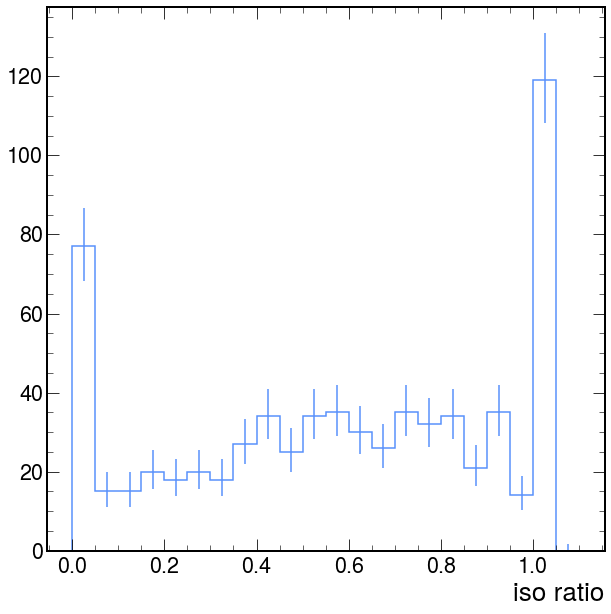

In [32]:
hist.Hist.new.Reg(22, 0, 1.1, name="iso ratio").Double(
).fill(
    ak.flatten(
        ak.where(muons.miniPFRelIso_all > 0, muons.miniPFRelIso_chg / muons.miniPFRelIso_all, 1)
    )
).plot()

In [12]:
muons.miniPFRelIso_all

<Array [[1.63, 1.87, 3.81, ... 3.23, 0.128, 0]] type='169 * var * float32[parame...'>

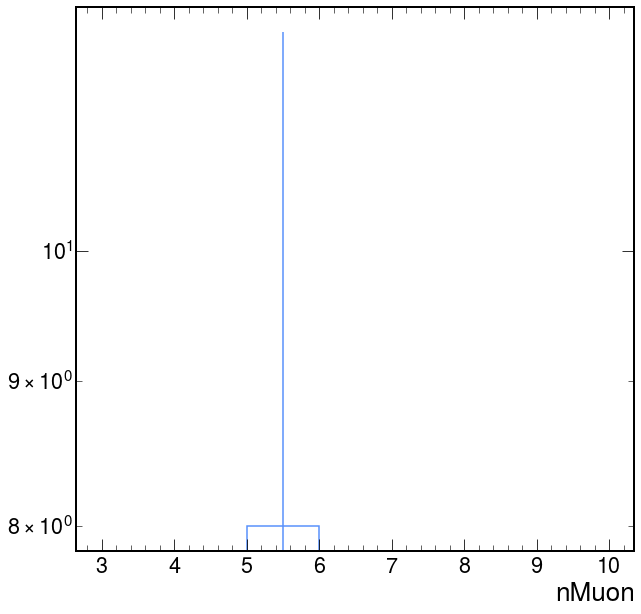

In [16]:
hist.Hist.new.Reg(7, 3, 10, name="nMuon").Double().fill(ak.num(muons)).plot()
plt.yscale('log')

In [80]:
gen_parts_final_from_S = gen_parts_final_from_S[select_by_muons_high]

In [40]:
ak_inclusive_jets, ak_inclusive_cluster = SUEP_utils.FastJetReclustering(
    ak.packed(Cleaned_cands), r=1.5, min_pt=0
)

In [41]:
# Make sure there are at least 2 jets
at_least_two_jets = ak.num(ak_inclusive_jets) >= 2
events = events[at_least_two_jets]
muons = muons[at_least_two_jets]
Cleaned_cands = Cleaned_cands[at_least_two_jets]
ak_inclusive_cluster = ak_inclusive_cluster[at_least_two_jets]
ak_inclusive_jets = ak_inclusive_jets[at_least_two_jets]

events, Cleaned_cands, muons, topTwoJets = SUEP_utils.getTopTwoJets(
    None, events, Cleaned_cands, muons, ak_inclusive_jets, ak_inclusive_cluster
)
SUEP_cand, ISR_cand, SUEP_cluster_tracks, ISR_cluster_tracks = topTwoJets

In [ ]:
gen_parts_final_from_S = gen_parts_final_from_S[at_least_two_jets]

In [42]:
ak.num(muons)

<Array [6, 6, 6, 6, 6, 7, 6] type='7 * int64'>

In [20]:
boost_SUEP = ak.zip(
    {
        "px": SUEP_cand.px * -1,
        "py": SUEP_cand.py * -1,
        "pz": SUEP_cand.pz * -1,
        "mass": SUEP_cand.mass,
    },
    with_name="Momentum4D",
)
SUEP_cluster_tracks_b = SUEP_cluster_tracks.boost_p4(
    boost_SUEP
)
eigs = SUEP_utils.sphericity(SUEP_cluster_tracks_b, 1.0)
sphericity = 1.5 * (eigs[:, 1] + eigs[:, 0])

In [21]:
print(len(muons[0]))
print(muons[0].energy)
print(muons[0].pt)
print(muons[0].eta)
print(muons[0].phi)

6

[177, 73.9, 39.6, 14.9, 13.2, 16.7]

[38.2, 30, 8.34, 7.84, 6.87, 6.57]

[2.22, 1.55, 2.24, 1.26, 1.27, 1.58]

[-0.0734, 2.88, -0.0966, 2.99, 3.08, 2.84]

In [22]:
events.Electron.energy

<Array [[70.7], [33.4, 39.5, ... [11.1], []] type='142 * var * float32'>

In [23]:
print(len(Cleaned_cands[0]))
print(ak.sort(Cleaned_cands[0].E, ascending=False).to_list())
print(ak.sort(Cleaned_cands[0].pt, ascending=False))
print(Cleaned_cands[0].eta[ak.argsort(Cleaned_cands[0].pt, ascending=False)])
print(Cleaned_cands[0].phi[ak.argsort(Cleaned_cands[0].pt, ascending=False)])

26

[
    177.3206787109375,
    73.89753723144531,
    42.06016159057617,
    39.64115905761719,
    23.077363967895508,
    16.677345275878906,
    14.93364143371582,
    13.182435989379883,
    8.884729385375977,
    7.072476387023926,
    4.708385944366455,
    4.646052837371826,
    4.3907880783081055,
    3.7419707775115967,
    3.6571097373962402,
    3.253474473953247,
    2.8953030109405518,
    2.583695650100708,
    1.6852344274520874,
    1.5507218837738037,
    1.3959122896194458,
    1.356154203414917,
    1.3543736934661865,
    1.3336057662963867,
    1.3298559188842773,
    1.1015894412994385
]

[38.2, 30, 8.34, 7.84, 7.21, 6.87, 6.57, ... 1.14, 1.13, 1.11, 1.07, 0.965, 0.768]

[2.22, 1.55, 2.24, 1.26, 2.45, 1.27, ... 0.566, -2.03, 1.49, 0.209, -0.906, -2.49]

[-0.0734, 2.88, -0.0966, 2.99, 0.156, 3.08, ... -2.45, 0.697, 1.15, 0.0522, 0.000969]

In [24]:
print(len(SUEP_cluster_tracks[0]))
print(SUEP_cluster_tracks[0].pt)
print(SUEP_cluster_tracks[0].eta)
print(SUEP_cluster_tracks[0].phi)

6

[7.21, 8.34, 38.2, 1.15, 1.11, 1.86]

[2.45, 2.24, 2.22, 1.82, 1.49, 1.32]

[0.156, -0.0966, -0.0734, 1.41, 0.697, 1.07]

In [25]:
print(len(SUEP_cluster_tracks_b[0]))
print(SUEP_cluster_tracks_b[0].pt)
print(SUEP_cluster_tracks_b[0].eta)
print(SUEP_cluster_tracks_b[0].phi)

6

[1.65, 1.03, 4.41, 1.55, 0.698, 1.79]

[0.777, 1.08, 1.11, -1.26, -1.54, -1.69]

[2.51, -1.17, -0.894, 2.34, 1.53, 2.02]

In [26]:
print(boost_SUEP[0].pt, boost_SUEP[0].eta, boost_SUEP[0].phi)

55.44901558770289 -2.258495693602967 -3.1234440835151664

In [27]:
boost_SUEP[0].beta, boost_SUEP[0].gamma

(0.9969506214136951, 12.814765512883643)

In [81]:
scalar = events.GenPart[(events.GenPart.pdgId==25) & (events.GenPart.status==62)]

In [82]:
scalar[0].E, scalar[0].p, scalar[0].pt, scalar[0].eta, scalar[0].phi

(<Array [438] type='1 * float32'>,
 <Array [420] type='1 * float32'>,
 <Array [17.7] type='1 * float32[parameters={"__doc__": "pt"}]'>,
 <Array [3.86] type='1 * float32[parameters={"__doc__": "eta"}]'>,
 <Array [0.572] type='1 * float32[parameters={"__doc__": "phi"}]'>)

In [88]:
true_boost = ak.zip(
    {
        "px": scalar.px * -1,
        "py": scalar.py * -1,
        "pz": scalar.pz * -1,
        "mass": scalar.mass,
    },
    with_name="Momentum4D",
)

In [31]:
print(true_boost[0].pt, true_boost[0].eta, true_boost[0].phi)

[17.7] [-3.86] [-2.57]

In [32]:
true_boost[0].beta, true_boost[0].gamma

(<Array [0.958] type='1 * float32'>, <Array [3.5] type='1 * float32'>)

In [33]:
print(sphericity)

[0.18119882 0.47108128 0.49306433 0.41994027 0.56598212 0.27916666
 0.08373001 0.49323016 0.32197137 0.6019326  0.25939788 0.08092569
 0.27792185 0.76226806 0.28090437 0.03448397 0.11336118 0.25719302
 0.37429969 0.56394626 0.43627706 0.51357169 0.26015139 0.34424681
 0.10951951 0.38013594 0.05091741 0.29664842 0.34207379 0.70479518
 0.49300881 0.48698174 0.37073834 0.69803306 0.40990743 0.87910416
 0.30575446 0.29201329 0.71139609 0.4955874  0.70626224 0.63010701
 0.21569872 0.40876834 0.58321218 0.25001194 0.5063164  0.62780833
 0.18485081 0.54272327 0.41709828 0.36653346 0.2639744  0.31648984
 0.63324742 0.29494779 0.81101789 0.51618879 0.51352713 0.52415556
 0.50717907 0.46370424 0.34067173 0.71769183 0.64283223 0.55612163
 0.15504666 0.26331594 0.68670132 0.04067068 0.4306784  0.51474108
 0.20897498 0.16130972 0.41134111 0.56188965 0.30751263 0.13860003
 0.61901945 0.60076731 0.49254517 0.42210897 0.49151773 0.35428927
 0.19897103 0.55878689 0.30774359 0.24706616 0.07407665 0.15706678
 0.41387877 0.46708882 0.25514245 0.44613587 0.40985771 0.11134659
 0.66462732 0.52624085 0.39613241 0.54343113 0.50342713 0.14824251
 0.62520846 0.14703149 0.55254264 0.28139586 0.6228372  0.6035747
 0.38175453 0.3898131  0.31804253 0.41499259 0.04042821 0.67288803
 0.78045819 0.35238061 0.61787353 0.44190723 0.65466005 0.4474342
 0.2018005  0.17356129 0.39876725 0.51068208 0.48368139 0.64495073
 0.24191546 0.47779613 0.69115929 0.24296096 0.45366084 0.56044336
 0.51111756 0.4057903  0.46719854 0.03931687 0.7559412  0.55924493
 0.54219455 0.59979379 0.64685872 0.18419483]

In [89]:
gen_parts_collection = ak.zip(
    {
        "px": gen_parts_final_from_S.px,
        "py": gen_parts_final_from_S.py,
        "pz": gen_parts_final_from_S.pz,
        "mass": gen_parts_final_from_S.mass,
    },
    with_name="Momentum4D",
)
gen_parts_collection_b = gen_parts_collection.boost_p4(
    ak.flatten(true_boost)
)
eigs = SUEP_utils.sphericity(gen_parts_collection_b, 1.0)
gen_sphericity = 1.5 * (eigs[:, 1] + eigs[:, 0])

In [35]:
gen_sphericity

array([0.02304995, 0.256774  , 0.10067432, 0.09861544, 0.20160842,
       0.01974778, 0.02200761, 0.01382332, 0.2736281 , 0.07053462,
       0.07511429, 0.02206   , 0.01370139, 0.6420889 , 0.0255059 ,
       0.02478112, 0.01605716, 0.01831445, 0.01769359, 0.11667924,
       0.01518179, 0.4035238 , 0.02645463, 0.07528631, 0.04032204,
       0.08395305, 0.02370308, 0.0212737 , 0.1645345 , 0.01405013,
       0.02414403, 0.7191677 , 0.01908587, 0.02716133, 0.02432302,
       0.14594953, 0.02859478, 0.2786099 , 0.32950485, 0.01455311,
       0.02896108, 0.01819452, 0.3481229 , 0.31152043, 0.44378442,
       0.5691829 , 0.05103671, 0.2766347 , 0.03548479, 0.02673315,
       0.10332066, 0.02405018, 0.25028965, 0.02055317, 0.01612943,
       0.01438508, 0.33268392, 0.40320212, 0.01439589, 0.02395898,
       0.02428959, 0.03533215, 0.01743213, 0.13787517, 0.5829377 ,
       0.14298461, 0.77097225, 0.01557068, 0.02425337, 0.3393774 ,
       0.02451088, 0.01495443, 0.02154048, 0.24240634, 0.02756

In [36]:
print(len(SUEP_cluster_tracks_tb[0]))
print(SUEP_cluster_tracks_tb[0].pt)
print(SUEP_cluster_tracks_tb[0].eta)
print(SUEP_cluster_tracks_tb[0].phi)

NameError: name 'SUEP_cluster_tracks_tb' is not defined

In [ ]:
print(len(SUEP_cluster_tracks[0]))
print(SUEP_cluster_tracks[0].pt)
print(SUEP_cluster_tracks[0].eta)
print(SUEP_cluster_tracks[0].phi)

In [37]:
Cleaned_cands

<MomentumArray4D [[{pt: 0.768, ... mass: 0.106}]] type='142 * var * Momentum4D["...'>

In [38]:
Cleaned_cands_tb = Cleaned_cands.boost_p4(
    ak.flatten(true_boost)
)
eigs = SUEP_utils.sphericity(Cleaned_cands_tb, 1.0)
sphericity_t = 1.5 * (eigs[:, 1] + eigs[:, 0])
print(sphericity_t)

[0.2531216  0.4682433  0.48730686 0.33017558 0.48475415 0.06635326
 0.29730812 0.4751026  0.28602833 0.3009733  0.3213411  0.12269193
 0.26780272 0.6421265  0.41996965 0.28208572 0.3294643  0.5011054
 0.60131335 0.43617463 0.33147037 0.2269987  0.61813176 0.41383576
 0.35514802 0.16148283 0.6394491  0.14494719 0.85596156 0.37678587
 0.7199091  0.40412834 0.6882622  0.29934934 0.31043506 0.3701416
 0.6093964  0.5909786  0.5251428  0.71470046 0.04668078 0.6070962
 0.55167365 0.05805388 0.4157328  0.5752414  0.15104571 0.56646365
 0.26472253 0.7030558  0.49353194 0.41827    0.5030607  0.4909026
 0.34758702 0.35962838 0.23591311 0.36677966 0.28437573 0.47129846
 0.5385394  0.3425827  0.5502372  0.38527566 0.74919355 0.7189777
 0.40277132 0.32890642 0.67161095 0.528588   0.30638057 0.6528096
 0.45974684 0.2909672  0.3487244  0.47118443 0.50094926 0.11350879
 0.49210748 0.2053239  0.32236698 0.03134482 0.3378175  0.7410573
 0.59313095 0.39128864 0.7990433  0.16527617 0.35150033 0.02084688
 0.4313879  0.42859653 0.62063295 0.4243014  0.7791744  0.22276658
 0.5209753  0.43888494 0.69872034 0.40723503 0.3061235  0.6870368
 0.13699025 0.3604732  0.1568367  0.10503671 0.4309671  0.36406475
 0.5566462  0.5099443  0.29875264 0.31501997 0.6430963  0.1485185
 0.41826984 0.17578325 0.4040409  0.7440371  0.48790768 0.5395906
 0.47157267 0.43499583 0.31282753 0.33291867 0.47557956 0.27248356
 0.4760083  0.35547125 0.49537694 0.51038617 0.17577383 0.13695122
 0.5729196  0.3787858  0.61059403 0.13375154 0.6382361  0.5381366
 0.3000282  0.6363334  0.2689062  0.5180908 ]

In [39]:
SUEP_cands_tb = Cleaned_cands.boost_p4(
    ak.flatten(true_boost)
)
eigs = SUEP_utils.sphericity(Cleaned_cands_tb, 1.0)
sphericity_t = 1.5 * (eigs[:, 1] + eigs[:, 0])
print(sphericity_t)

[0.2531216  0.4682433  0.48730686 0.33017558 0.48475415 0.06635326
 0.29730812 0.4751026  0.28602833 0.3009733  0.3213411  0.12269193
 0.26780272 0.6421265  0.41996965 0.28208572 0.3294643  0.5011054
 0.60131335 0.43617463 0.33147037 0.2269987  0.61813176 0.41383576
 0.35514802 0.16148283 0.6394491  0.14494719 0.85596156 0.37678587
 0.7199091  0.40412834 0.6882622  0.29934934 0.31043506 0.3701416
 0.6093964  0.5909786  0.5251428  0.71470046 0.04668078 0.6070962
 0.55167365 0.05805388 0.4157328  0.5752414  0.15104571 0.56646365
 0.26472253 0.7030558  0.49353194 0.41827    0.5030607  0.4909026
 0.34758702 0.35962838 0.23591311 0.36677966 0.28437573 0.47129846
 0.5385394  0.3425827  0.5502372  0.38527566 0.74919355 0.7189777
 0.40277132 0.32890642 0.67161095 0.528588   0.30638057 0.6528096
 0.45974684 0.2909672  0.3487244  0.47118443 0.50094926 0.11350879
 0.49210748 0.2053239  0.32236698 0.03134482 0.3378175  0.7410573
 0.59313095 0.39128864 0.7990433  0.16527617 0.35150033 0.02084688
 0.4313879  0.42859653 0.62063295 0.4243014  0.7791744  0.22276658
 0.5209753  0.43888494 0.69872034 0.40723503 0.3061235  0.6870368
 0.13699025 0.3604732  0.1568367  0.10503671 0.4309671  0.36406475
 0.5566462  0.5099443  0.29875264 0.31501997 0.6430963  0.1485185
 0.41826984 0.17578325 0.4040409  0.7440371  0.48790768 0.5395906
 0.47157267 0.43499583 0.31282753 0.33291867 0.47557956 0.27248356
 0.4760083  0.35547125 0.49537694 0.51038617 0.17577383 0.13695122
 0.5729196  0.3787858  0.61059403 0.13375154 0.6382361  0.5381366
 0.3000282  0.6363334  0.2689062  0.5180908 ]

In [40]:
print(len(Cleaned_cands_tb[0]))
print(ak.sort(Cleaned_cands_tb[0].E, ascending=False))
print(Cleaned_cands_tb[0].pt)
print(Cleaned_cands_tb[0].eta)
print(Cleaned_cands_tb[0].phi)

26

[157, 60.6, 48.1, 36, 35.1, 31.5, 29.8, ... 4.67, 3.45, 2.98, 2.47, 2, 1.08, 1.07]

[0.643, 5.82, 7.23, 33.1, 1.06, 7.08, 32.4, ... 0.721, 0.611, 2.2, 3.32, 10.2, 3.95]

[-4.59, 0.723, 0.442, 0.418, -0.0475, -0.38, ... -4.24, -3.3, -3.36, -3.42, -3.42]

[-1.87, 0.0485, -0.225, -0.196, 1.51, 2.93, ... 1.31, -2.51, -2.73, -2.34, -2.57]

In [53]:
events.fields

['Electron',
 'HLT',
 'SubJet',
 'luminosityBlock',
 'Tau',
 'Jet',
 'SoftActivityJetNjets2',
 'DeepMETResolutionTune',
 'genTtbarId',
 'TkMET',
 'LHEPdfWeight',
 'HLTriggerFinalPath',
 'L1simulation',
 'FatJet',
 'LHEWeight',
 'GenMET',
 'Pileup',
 'SoftActivityJetHT',
 'event',
 'PuppiMET',
 'Photon',
 'PSWeight',
 'run',
 'IsoTrack',
 'GenJet',
 'RawMET',
 'TrigObj',
 'PV',
 'GenVtx',
 'DeepMETResponseTune',
 'L1Reco',
 'MET',
 'LHEScaleWeight',
 'L1PreFiringWeight',
 'fixedGridRhoFastjetCentralChargedPileUp',
 'GenModel',
 'Flag',
 'Muon',
 'SoftActivityJetNjets5',
 'SoftActivityJetNjets10',
 'GenVisTau',
 'PFCands',
 'SoftActivityJetHT5',
 'GenJetAK8',
 'fixedGridRhoFastjetAll',
 'fixedGridRhoFastjetCentralNeutral',
 'genWeight',
 'fixedGridRhoFastjetCentral',
 'L1',
 'boostedTau',
 'RawPuppiMET',
 'SubGenJetAK8',
 'OtherPV',
 'CorrT1METJet',
 'ChsMET',
 'HLTriggerFirstPath',
 'SoftActivityJetHT2',
 'FsrPhoton',
 'SoftActivityJetHT10',
 'fixedGridRhoFastjetCentralCalo',
 'SV',
 'G

In [23]:
events.PFCands.fields

['d0',
 'd0Err',
 'dz',
 'dzErr',
 'eta',
 'mass',
 'phi',
 'pt',
 'puppiWeight',
 'puppiWeightNoLep',
 'trkChi2',
 'trkEta',
 'trkPhi',
 'trkPt',
 'vtxChi2',
 'charge',
 'fromPV',
 'lostInnerHits',
 'pdgId',
 'pvAssocQuality',
 'trkQuality']

In [11]:
muons

<MuonArray [[Muon, Muon, Muon, ... Muon, Muon]] type='169 * var * muon'>

In [12]:
argcombs = ak.argcombinations(muons, 2)

In [13]:
argcombs

<Array [[(0, 1), (0, 2), (, ... 1, 3), (2, 3)]] type='169 * var * (int64, int64)'>

In [14]:
muon1, muon2 = ak.unzip(ak.combinations(muons, 2))

In [15]:
muon1.fields

['dxy',
 'dxyErr',
 'dxybs',
 'dz',
 'dzErr',
 'eta',
 'ip3d',
 'jetPtRelv2',
 'jetRelIso',
 'mass',
 'miniPFRelIso_all',
 'miniPFRelIso_chg',
 'pfRelIso03_all',
 'pfRelIso03_chg',
 'pfRelIso04_all',
 'phi',
 'pt',
 'ptErr',
 'segmentComp',
 'sip3d',
 'softMva',
 'tkRelIso',
 'tunepRelPt',
 'mvaLowPt',
 'mvaTTH',
 'charge',
 'jetIdx',
 'nStations',
 'nTrackerLayers',
 'pdgId',
 'tightCharge',
 'fsrPhotonIdx',
 'highPtId',
 'highPurity',
 'inTimeMuon',
 'isGlobal',
 'isPFcand',
 'isStandalone',
 'isTracker',
 'jetNDauCharged',
 'looseId',
 'mediumId',
 'mediumPromptId',
 'miniIsoId',
 'multiIsoId',
 'mvaId',
 'mvaLowPtId',
 'pfIsoId',
 'puppiIsoId',
 'softId',
 'softMvaId',
 'tightId',
 'tkIsoId',
 'triggerIdLoose',
 'genPartIdx',
 'genPartFlav',
 'cleanmask',
 'fsrPhotonIdxG',
 'genPartIdxG',
 'jetIdxG']

In [16]:
events.Jet[muons.jetIdx[muons.jetIdx >= 0]].btagDeepFlavB

<Array [[0.135, 0.135, ... 0.649, 0.13]] type='169 * var * float32[parameters={"...'>

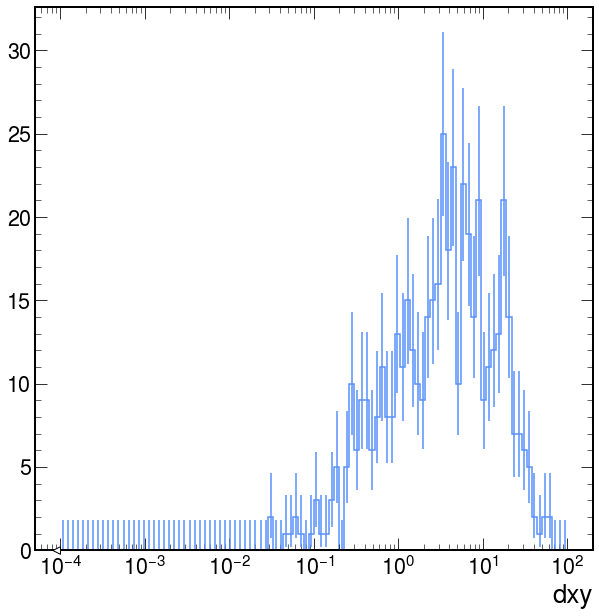

In [99]:
hist.Hist.new.Reg(
    100, 1e-4, 100, name="dxy", transform=hist.axis.transform.log
).Double().fill(ak.flatten(muons.miniPFRelIso_chg)).plot()
plt.xscale('log')

In [17]:
os_mask = muon1.charge != muon2.charge
muon1, muon2 = muon1[os_mask], muon2[os_mask]

In [18]:
argcombs = argcombs[os_mask]

In [19]:
print(argcombs)

[[(0, 1), (0, 2), (0, 3)], [(0, 1), (0, 2), ... (0, 1), (0, 3), (1, 2), (2, 3)], []]

In [20]:
muon1_collection = ak.zip(
    {
        "px": muon1.px,
        "py": muon1.py,
        "pz": muon1.pz,
        "mass": muon1.mass,
    },
    with_name="Momentum4D",
)
muon2_collection = ak.zip(
    {
        "px": muon2.px,
        "py": muon2.py,
        "pz": muon2.pz,
        "mass": muon2.mass,
    },
    with_name="Momentum4D",
)
dimuon_collection = muon1_collection + muon2_collection

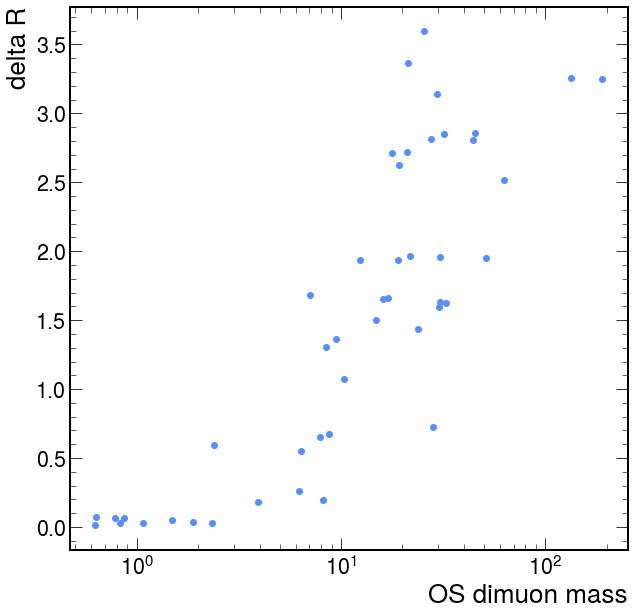

In [22]:
plt.scatter(ak.flatten(dimuon_collection.mass), ak.flatten(muon1.delta_r(muon2)))
plt.xlabel("OS dimuon mass")
plt.ylabel("delta R")
plt.xscale('log')

In [21]:
muon1[0]

<MuonArray [Muon, Muon, Muon] type='3 * muon'>

In [22]:
dimuon_collection[0]

<MomentumArray4D [{x: -93.3, y: 4.54, ... tau: 44}] type='3 * Momentum4D["x": fl...'>

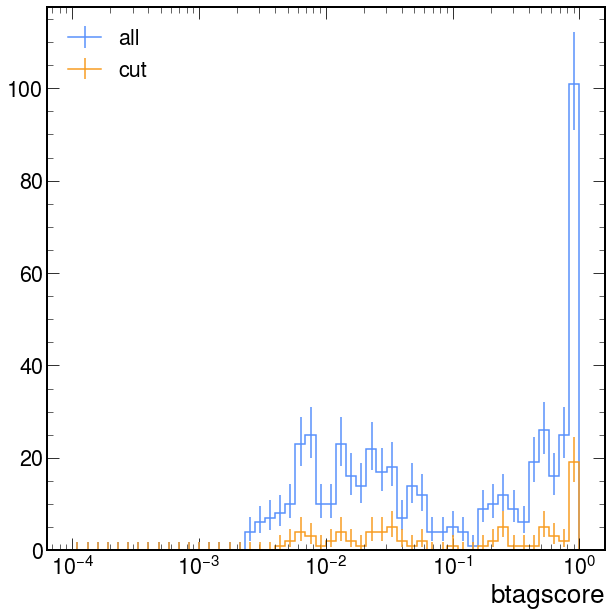

In [103]:
hist.Hist.new.Reg(
    50, 1e-4, 1, name="btagscore", transform=hist.axis.transform.log
).Double().fill(
    ak.flatten(
        events.Jet[muons.jetIdx[muons.jetIdx >= 0]].btagDeepFlavB
    )
).plot(label="all")
hist.Hist.new.Reg(
    50, 1e-4, 1, name="btagscore", transform=hist.axis.transform.log
).Double().fill(
    ak.flatten(
        events.Jet[
            muon1[(muon1.jetIdx >= 0) & (dimuon_collection.mass < 1)].jetIdx
        ].btagDeepFlavB
    )
).plot(label="cut")
plt.xscale('log')
plt.legend()
plt.show()

In [23]:
dark_photons = dimuon_collection[dimuon_collection.mass < 1]

In [24]:
print(dark_photons.mass)

[[], [0.726], [], [0.764], [], [], [], ... [], [], [], [0.522], [], [0.82], []]

In [25]:
argcombs = argcombs[dimuon_collection.mass < 1]

In [26]:
print(ak.num(argcombs))

[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ... 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]

In [27]:
print(dark_photons.mass)

[[], [0.726], [], [0.764], [], [], [], ... [], [], [], [0.522], [], [0.82], []]

In [28]:
print(muon1_collection[dimuon_collection.mass < 1].deltaR(muon2_collection[dimuon_collection.mass < 1]))

[[], [0.0109], [], [0.0449], [], [], [], ... [], [], [], [0.0696], [], [0.0922], []]

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fd47a333c10>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

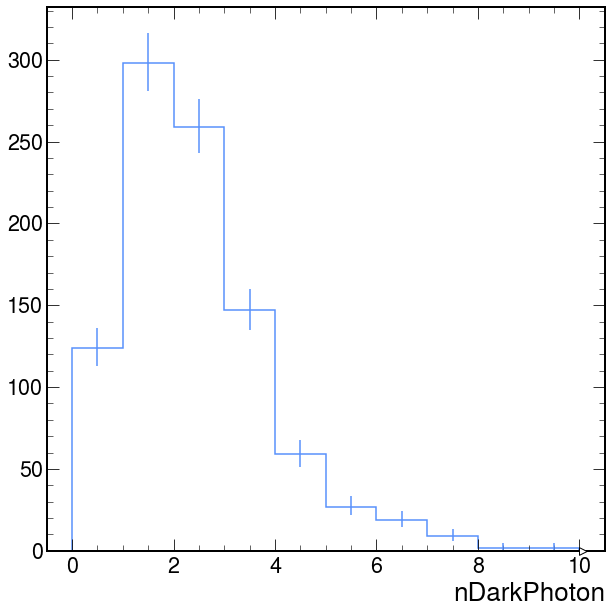

In [18]:
hist.Hist.new.Reg(10, 0, 10, name="nDarkPhoton").Double().fill(ak.num(dark_photons)).plot()

In [29]:
Aprime1, Aprime2 = ak.unzip(ak.combinations(dark_photons, 2))

In [43]:
argcombs_2 = ak.argcombinations(dark_photons, 2)

In [44]:
print(argcombs_2[ak.num(argcombs_2) > 0])

[[(0, 1)], [(0, 1)], ... (0, 1), (0, 2), (1, 2)], [(0, 1), (0, 2), (1, 2)], [(0, 1)]]

In [38]:
ak.flatten(Aprime1.deltaR(Aprime2))

<Array [2.01, 0.0365, ... 0.0459, 0.0228] type='9 * float32'>

In [39]:
dark_meson_cands = Aprime1 + Aprime2

In [40]:
ak.num(dark_photons.pt)

<Array [0, 1, 0, 1, 0, 0, ... 0, 0, 1, 0, 1, 0] type='169 * int64'>

In [41]:
ak.num(dark_meson_cands)

<Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='169 * int64'>

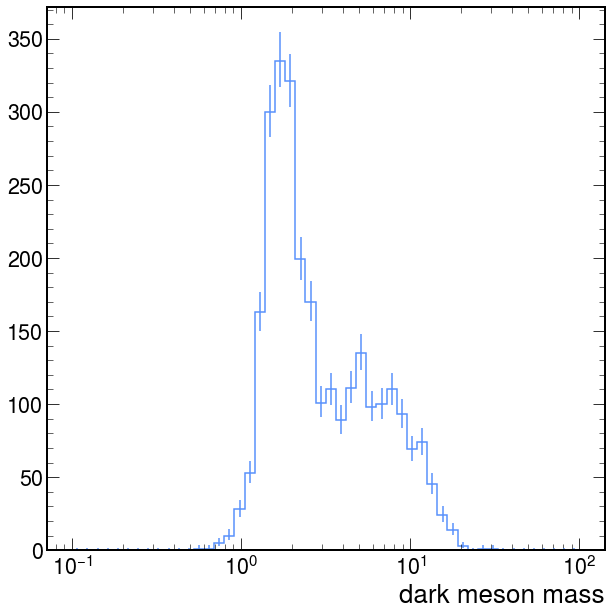

In [24]:
hist.Hist.new.Reg(
    50, 0.1, 100, name="dark meson mass", transform=hist.axis.transform.log
).Double().fill(ak.flatten(dark_meson_cands.mass)).plot()
plt.xscale('log')

In [42]:
dark_mesons = dark_meson_cands[(dark_meson_cands.mass > 1) & (dark_meson_cands.mass < 10)]

In [45]:
argcombs_2 = argcombs_2[(dark_meson_cands.mass > 1) & (dark_meson_cands.mass < 10)]

In [47]:
print(argcombs_2[ak.num(argcombs_2) > 0])

[[(0, 1)], [(0, 1), (0, 2), (1, 2)], [(0, 1), (0, 2), (1, 2)], [(0, 1)]]

In [51]:
print((Aprime1[(dark_meson_cands.mass > 1) & (dark_meson_cands.mass < 10)])[ak.num(argcombs_2) > 0].deltaR(
    (Aprime2[(dark_meson_cands.mass > 1) & (dark_meson_cands.mass < 10)])[ak.num(argcombs_2) > 0]
))

[[0.0365], [0.012, 0.021, 0.0311], [0.0433, 0.0177, 0.0459], [0.0228]]

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fd4d52dbad0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

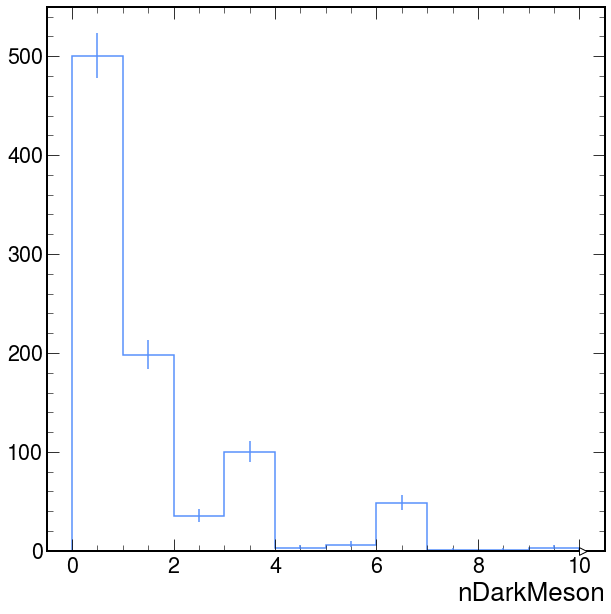

In [26]:
hist.Hist.new.Reg(10, 0, 10, name="nDarkMeson").Double().fill(ak.num(dark_mesons)).plot()

In [ ]:
def get_closest_OS_pairs(
    self,
    other,
    axis=1,
    metric=lambda a, b: a.delta_r(b),
    return_metric=False,
    threshold=None,
):
    mval, (a, b) = self.metric_table(other, axis, metric, return_combinations=True)
    if axis is None:
        # NotImplementedError: awkward.firsts with axis=-1
        axis = other.layout.purelist_depth - 2
    mmin = awkward.argmin(mval, axis=axis + 1, keepdims=True)
    out = awkward.firsts(b[mmin], axis=axis + 1)
    metric = awkward.firsts(mval[mmin], axis=axis + 1)
    if threshold is not None:
        out = out.mask[metric <= threshold]
    if return_metric:
        return out, metric
    return out

In [83]:
ak8jets, ak8jetws_cluster = SUEP_utils.FastJetReclustering(
    ak.packed(Cleaned_cands), r=0.8, min_pt=10
)

In [84]:
def get_dr_ring(dr, phi_c=0, eta_c=0, n_points=600):
    deta = np.linspace(-dr, +dr, n_points)
    dphi = np.sqrt(dr**2 - np.square(deta))
    deta = eta_c+np.concatenate((deta, deta[::-1]))
    dphi = phi_c+np.concatenate((dphi, -dphi[::-1]))
    return dphi, deta

In [67]:
iEvt = 1
print("\teta\tphi\tcharge")
print(np.array([muons[iEvt].eta, muons[iEvt].phi, muons[iEvt].charge]).T)

eta     phi     charge

[[-1.70214844  2.51708984  1.        ]
 [-0.90356445 -1.72802734  1.        ]
 [-1.72265625  2.54296875 -1.        ]
 [-0.86499023 -1.77026367 -1.        ]
 [-1.24951172  2.38818359  1.        ]
 [-1.40380859  2.33789062 -1.        ]
 [-0.61035156 -1.04394531  1.        ]]

In [59]:
muons.nearest(muons, threshold=1, return_metric=True)

(<MuonArray [[Muon, Muon, Muon, ... Muon, Muon]] type='379 * var * ?muon'>,
 <Array [[0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0]] type='379 * var * ?float32'>)

In [55]:
print(muons[0].pt)
print(muons[0].eta)
print(muons[0].phi)
print(muons[0].charge)

[38.2, 30, 8.34, 7.84, 6.87, 6.57]

[2.22, 1.55, 2.24, 1.26, 1.27, 1.58]

[-0.0734, 2.88, -0.0966, 2.99, 3.08, 2.84]

[-1, 1, 1, 1, -1, -1]

In [54]:
print(nearest_muons.pt)
print(nearest_muons.eta)
print(nearest_muons.phi)
print(nearest_muons.charge)

[[38.2, 30, 8.34, 7.84, 6.87, 6.57], ... [25.8, 22.8, 19.1, 16, 12.9, 3.55]]

[[2.22, 1.55, 2.24, 1.26, 1.27, 1.58, ... -0.64, -1.18, -1.42, -1.46, -0.847, -1.24]]

[[-0.0734, 2.88, -0.0966, 2.99, 3.08, 2.84, ... 2.77, 2.86, 2.86, -0.764, 2.81]]

[[-1, 1, 1, 1, -1, -1], [1, 1, -1, -1, 1, ... -1, -1, 1, 1], [-1, -1, -1, 1, -1, 1]]

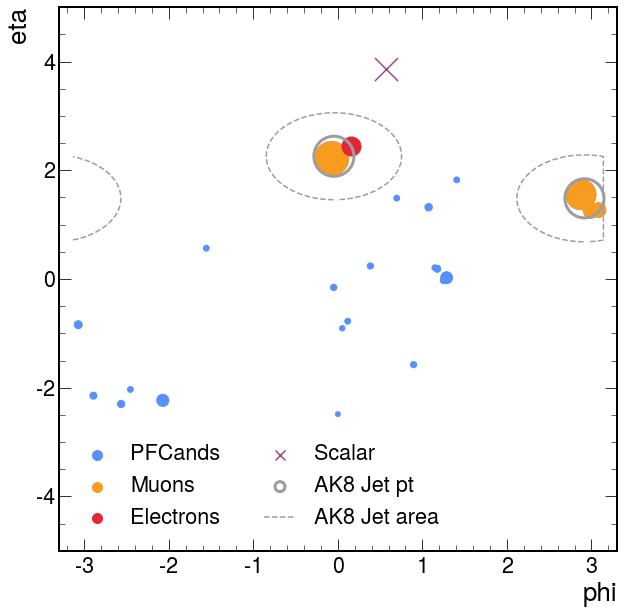

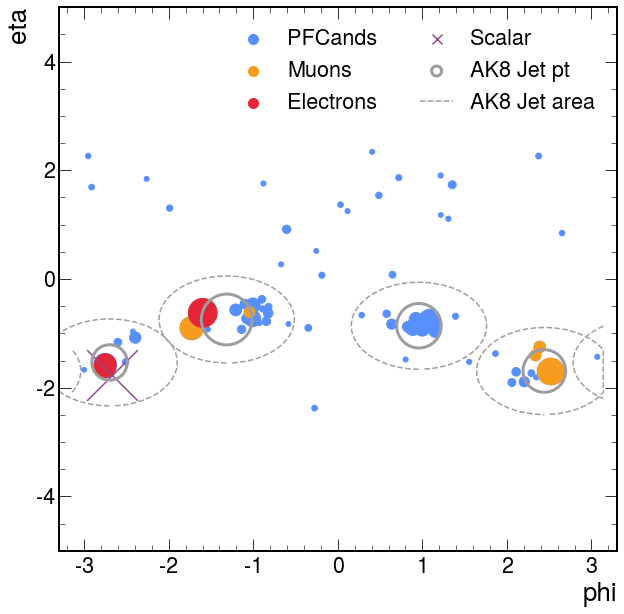

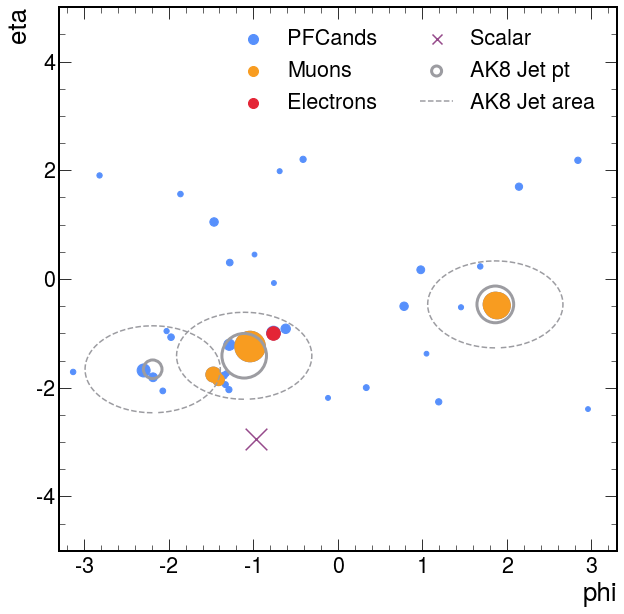

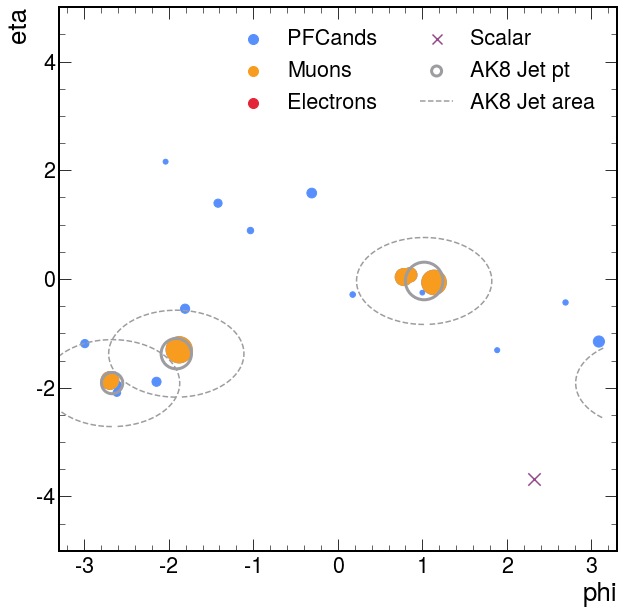

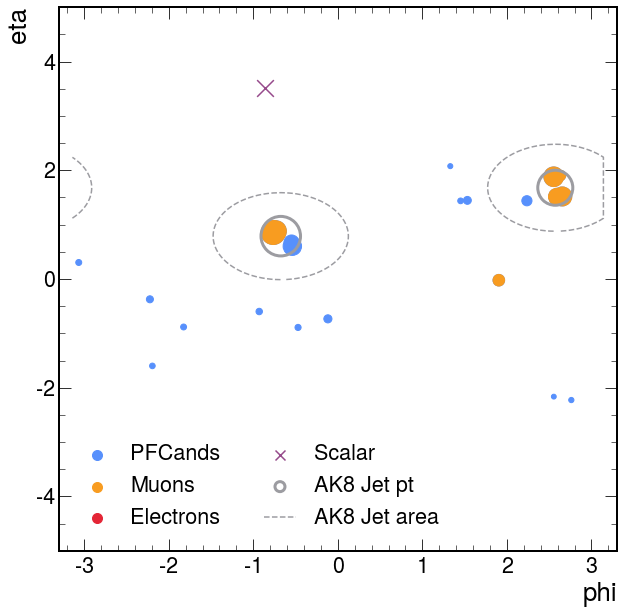

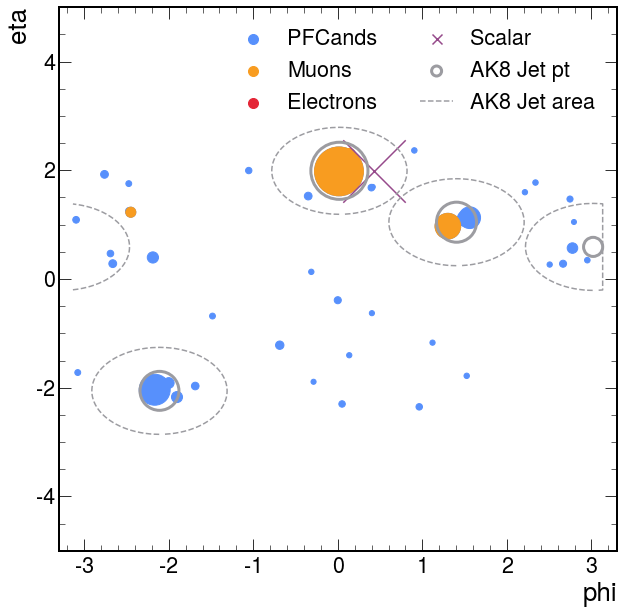

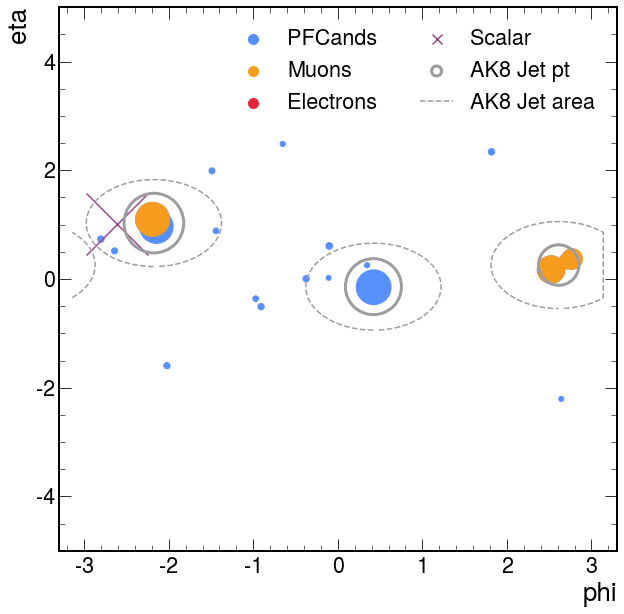

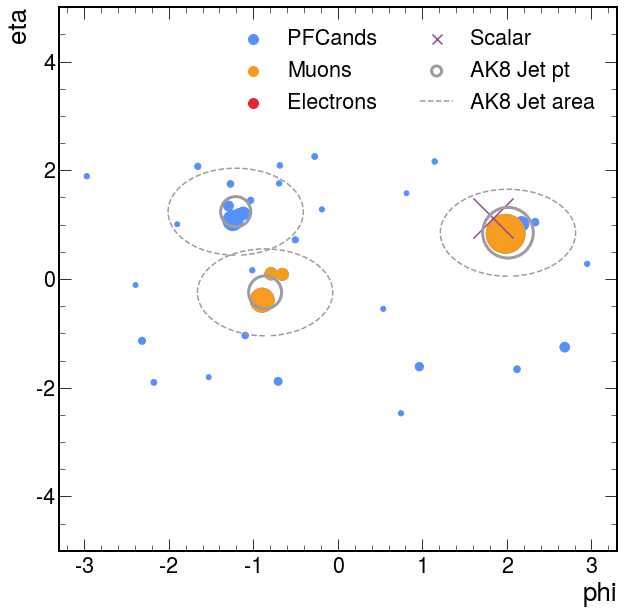

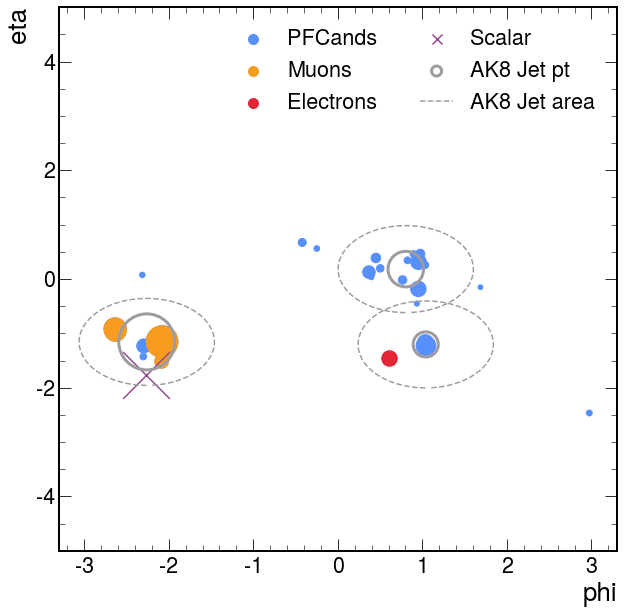

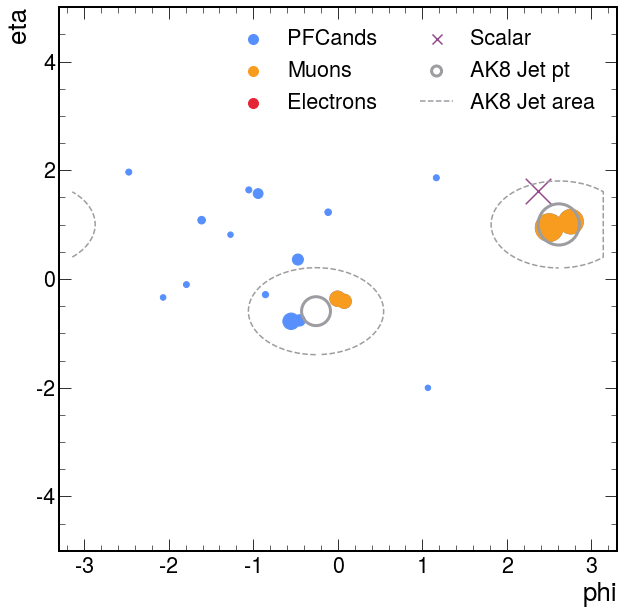

In [85]:
iEvt = 0
for iEvt in range(10): #range(len(events)):
    #print(f"sph = {sphericity_t[iEvt]:.3f}")
    plt.scatter(Cleaned_cands[iEvt].phi, Cleaned_cands[iEvt].eta, s=30*Cleaned_cands[iEvt].pt)
    plt.scatter(muons[iEvt].phi, muons[iEvt].eta, s=30*muons[iEvt].pt)
    plt.scatter(events.Electron[iEvt].phi, events.Electron[iEvt].eta, s=30*events.Electron[iEvt].pt)
    plt.scatter(scalar[iEvt].phi, scalar[iEvt].eta, s=30*scalar[iEvt].pt, marker='x')
    plt.scatter(
        ak8jets[iEvt].phi, ak8jets[iEvt].eta, s=30*ak8jets[iEvt].pt,
        facecolors='none', edgecolors='C4', lw=3
    )

    for jet in ak8jets[iEvt]:
        phis, etas = get_dr_ring(0.8, jet.phi, jet.eta)
        phis = phis[1:]
        etas = etas[1:]
        plt.plot(phis[phis>math.pi]-2*math.pi, etas[phis>math.pi], color='C4', linestyle='--')
        plt.plot(phis[phis<-math.pi]+2*math.pi, etas[phis<-math.pi], color='C4', linestyle='--')
        plt.plot(phis[phis<math.pi], etas[phis<math.pi], color='C4', linestyle='--')

    plt.xlim(-3.3, 3.3)
    plt.ylim(-5, 5)
    plt.xlabel('phi')
    plt.ylabel('eta')
    plt.scatter([], [], s=100, color='C0', label="PFCands")
    plt.scatter([], [], s=100, color='C1', label="Muons")
    plt.scatter([], [], s=100, color='C2', label="Electrons")
    plt.scatter([], [], s=100, color='C3', marker='x', label="Scalar")
    plt.scatter([], [], s=100, color='C4', facecolors='none', edgecolors='C4', lw=3, label="AK8 Jet pt")
    plt.plot([], [], color='C4', linestyle='--', label="AK8 Jet area")
    plt.legend(ncol=2)
    plt.show()

nGenParts = 26.000

nGenParts = 26.000

nGenParts = 8.000

nMuon = 6.000

nGenMuon = 6.000

sph = 0.023

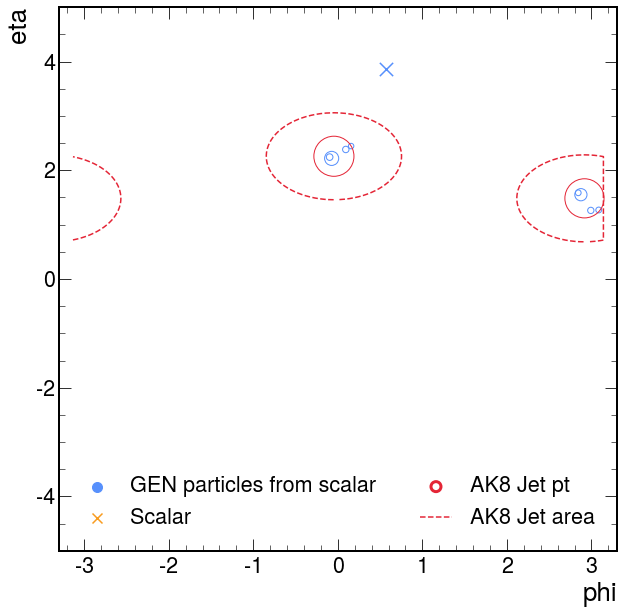

nGenParts = 78.000

nGenParts = 78.000

nGenParts = 10.000

nMuon = 7.000

nGenMuon = 6.000

sph = 0.257

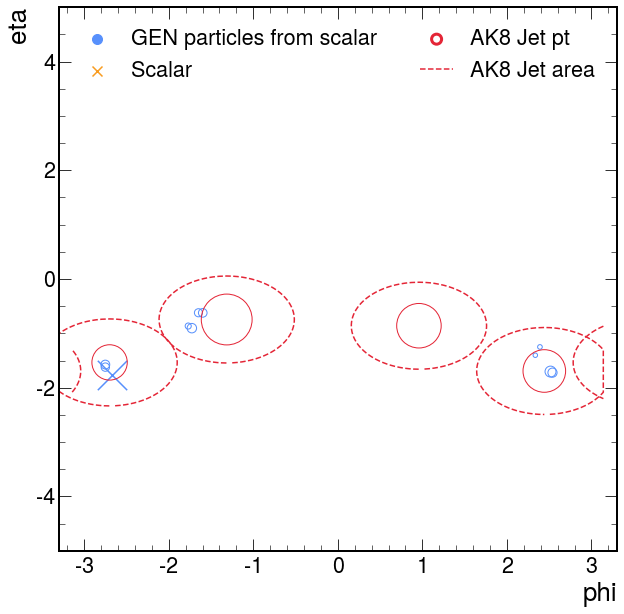

nGenParts = 38.000

nGenParts = 38.000

nGenParts = 8.000

nMuon = 6.000

nGenMuon = 6.000

sph = 0.101

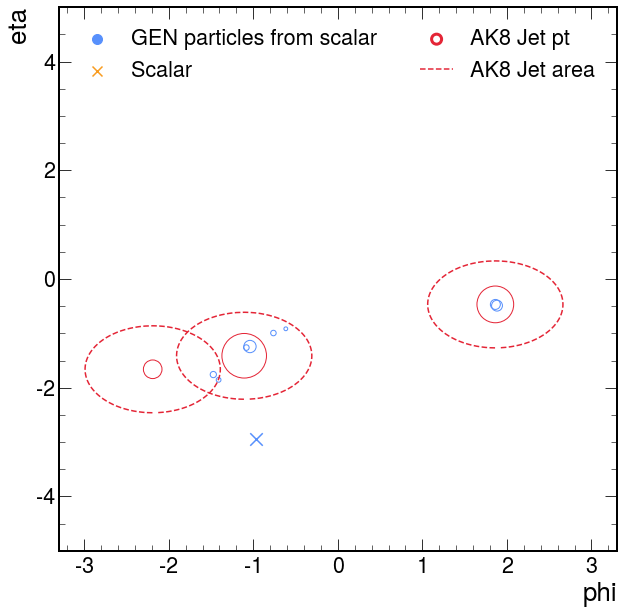

nGenParts = 21.000

nGenParts = 21.000

nGenParts = 8.000

nMuon = 7.000

nGenMuon = 8.000

sph = 0.099

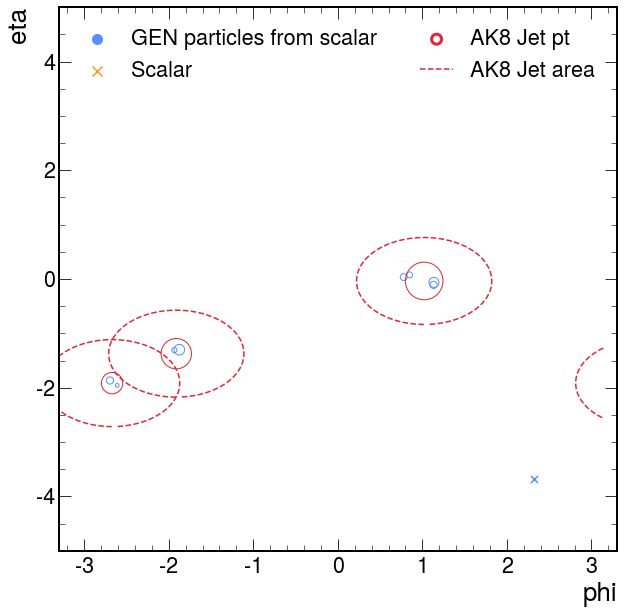

In [94]:
iEvt = 1
for iEvt in range(4):
    print(f"nGenParts = {ak.num(Cleaned_cands)[iEvt]:.3f}")
    print(f"nGenParts = {ak.num(Cleaned_cands)[iEvt]:.3f}")
    print(f"nGenParts = {ak.num(gen_parts_collection)[iEvt]:.3f}")
    print(f"nMuon = {ak.num(muons)[iEvt]:.3f}")
    print(f"nGenMuon = {ak.sum(abs(gen_parts_final_from_S.pdgId) == 13, axis=-1)[iEvt]:.3f}")
    print(f"sph = {gen_sphericity[iEvt]:.3f}")
    plt.scatter(
        gen_parts_collection[iEvt].phi, gen_parts_collection[iEvt].eta, s=5*gen_parts_collection[iEvt].pt, 
        facecolors='none', edgecolors='C0'
    )
    plt.scatter(scalar[iEvt].phi, scalar[iEvt].eta, s=10*scalar[iEvt].pt, marker='x')
    plt.scatter(
        ak8jets[iEvt].phi, ak8jets[iEvt].eta, s=30*ak8jets[iEvt].pt,
        facecolors='none', edgecolors='C2'
    )
    for jet in ak8jets[iEvt]:
        phis, etas = get_dr_ring(0.8, jet.phi, jet.eta)
        phis = phis[1:]
        etas = etas[1:]
        plt.plot(phis[phis>math.pi]-2*math.pi, etas[phis>math.pi], color='C2', linestyle='--')
        plt.plot(phis[phis<-math.pi]+2*math.pi, etas[phis<-math.pi], color='C2', linestyle='--')
        plt.plot(phis[phis<math.pi], etas[phis<math.pi], color='C2', linestyle='--')

    plt.xlim(-3.3, 3.3)
    plt.ylim(-5, 5)
    plt.xlabel('phi')
    plt.ylabel('eta')
    plt.scatter([], [], s=100, color='C0', label="GEN particles from scalar")
    plt.scatter([], [], s=100, color='C1', marker='x', label="Scalar")
    plt.scatter([], [], s=100, color='C2', facecolors='none', edgecolors='C2', lw=3, label="AK8 Jet pt")
    plt.plot([], [], color='C2', linestyle='--', label="AK8 Jet area")
    plt.legend(ncol=2)
    plt.show()

In [48]:
scalar_reco = (
    gen_parts_collection[iEvt][0] +
    gen_parts_collection[iEvt][2] +
    gen_parts_collection[iEvt][3] +
    gen_parts_collection[iEvt][4] +
    gen_parts_collection[iEvt][5]
)


In [50]:
scalar_reco.mass

109.36295318603516

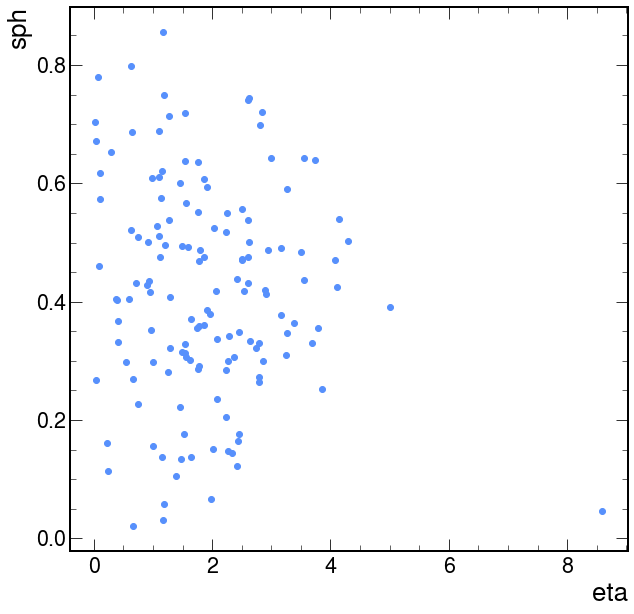

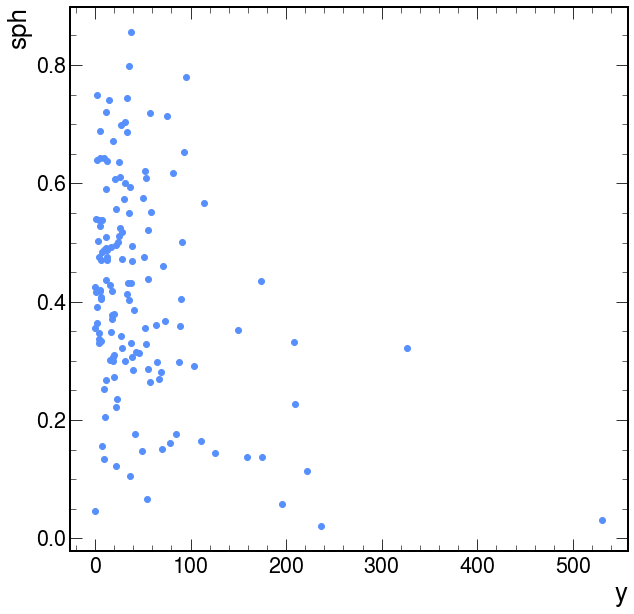

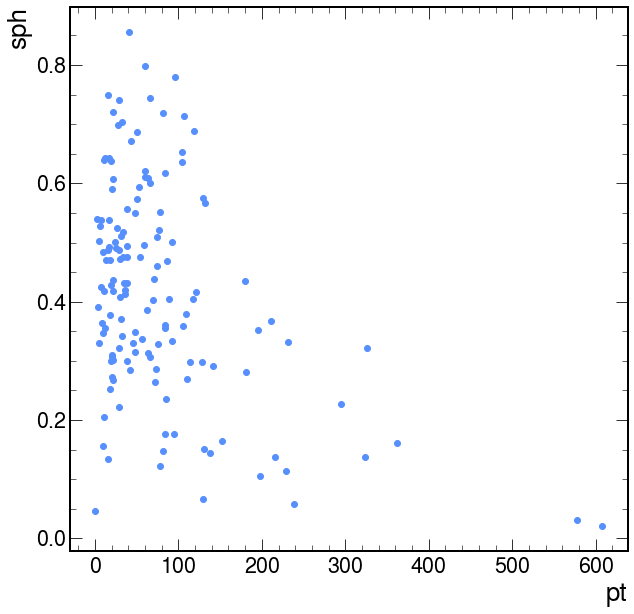

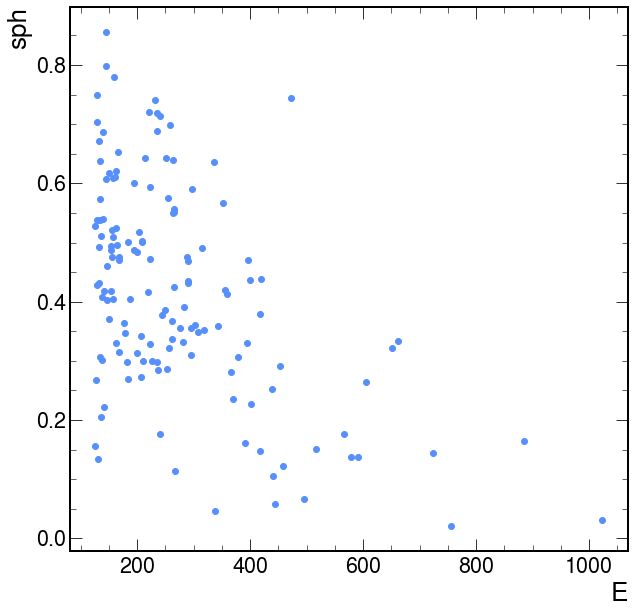

In [37]:
plt.scatter(abs(scalar.eta), sphericity_t)
plt.xlabel('eta')
plt.ylabel('sph')
plt.show()
plt.scatter(abs(scalar.y), sphericity_t)
plt.xlabel('y')
plt.ylabel('sph')
plt.show()
plt.scatter(scalar.pt, sphericity_t)
plt.xlabel('pt')
plt.ylabel('sph')
plt.show()
plt.scatter(scalar.E, sphericity_t)
plt.xlabel('E')
plt.ylabel('sph')
plt.show()

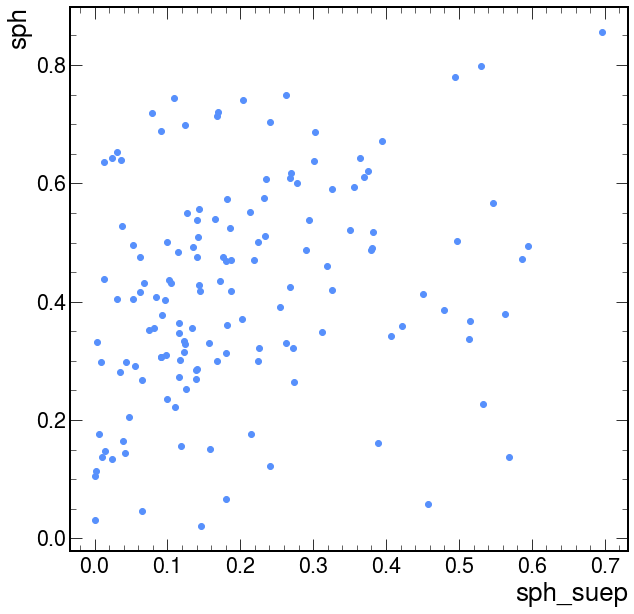

In [38]:
plt.scatter(sphericity_suep_t, sphericity_t)
plt.xlabel('sph_suep')
plt.ylabel('sph')
plt.show()